In [1]:
import pandas as pd

In [27]:
from scipy import stats
import numpy as np

## Remove outliers using Z score

def drop_coordinates_outliers(data):
    data = data.copy()
    print('Data shape before removing outliers: ', data.shape)
    data = data[((data.lat > 0.0)&(data.lon> 0.0))]
    z_lat, z_lon = np.abs(stats.zscore(data.lat)), np.abs(stats.zscore(data.lon))
    
    threshold = 2.5
    lat_outliers = np.where(z_lat > threshold)
    lon_outliers = np.where(z_lon > threshold)
    
    data_no_outliers = data.loc[~data.index.isin(np.concatenate((lat_outliers[0], lon_outliers[0])))].reset_index(drop=True)
    print('Data shape after removing outliers: ', data.shape)
    return data_no_outliers

### First of all we need to know the bounds of area which we will use for training

In [3]:
valid = pd.read_csv('./valid.csv')
valid = valid.drop_duplicates()

valid['hour'] = pd.to_datetime(valid['hour'], unit='s')

In [4]:
valid_no_outliers = drop_coordinates_outliers(data=valid.copy())
valid_no_outliers.head(5)

Data shape before removing outliers:  (709, 6)
Data shape after removing outliers:  (686, 6)


,hour,lat,lon,point,sum,error
0,2020-02-23 09:00:00,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,2020-02-20 19:00:00,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,2020-02-09 15:00:00,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,2020-02-17 17:00:00,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,2020-02-27 05:00:00,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [12]:
LAT_MIN_BOUND, LAT_MAX_BOUND = valid_no_outliers.lat.min(), valid_no_outliers.lat.max()
LON_MIN_BOUND, LON_MAX_BOUND = valid_no_outliers.lon.min(), valid_no_outliers.lon.max()

In [69]:
print('Rectangle of interest: ', LAT_MIN_BOUND, LAT_MAX_BOUND, LON_MIN_BOUND, LON_MAX_BOUND)

Rectangle of interest:  59.82893394227072 60.03933228251395 30.14296935863054 30.53598229543283


## Read and process train data according to rectangle of interest

In [8]:
train = pd.read_csv('./train_data.zip')
print('Train before dropping duplicates: ', train.shape)

train = train.drop_duplicates()
print('Train after dropping duplicates: ', train.shape)

# Filter all locations with less than 5 events in it 
train = train.groupby("point").filter(lambda x: len(x) > 5)
print('Train after filtering out rare cubes: ', train.shape)

# Convert unix timestamp to normal time
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train = train.reset_index(drop=True)

Train before dropping duplicates:  (8526526, 12)
Train after dropping duplicates:  (8456776, 12)
Train after filtering out rare cubes:  (8454375, 12)


In [9]:
# Drop all cubes that are not included in rectangle of interest
train_processed = train[((train.lat <= LAT_MAX_BOUND)&(train.lat >= LAT_MIN_BOUND)&(train.lon <= LON_MAX_BOUND)&(train.lon >= LON_MIN_BOUND))]
print('Train after removing cubes which are out of rectangle of interest: ', train_processed.shape)

Train after removing cubes which are out of rectangle of interest:  (8295361, 12)


In [45]:
train_processed.head(5)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427
3,2019-08-12 00:00:00,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,202,427
4,2019-08-12 00:00:00,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...,213,454


In [46]:
min_lat, max_lat = train_processed.lat.min(), train_processed.lat.max()
min_lon, max_lon = train_processed.lon.min(), train_processed.lon.max()

In [12]:
print('Rectangle of interest in train data: ', min_lat, max_lat, min_lon, max_lon)

Rectangle of interest in train data:  59.82893394227072 60.03933228251395 30.14521514684084 30.53598229543283


## Move coordinates to "image" grid

In [13]:
def lat_to_grid(inp):
    return round((LAT_MAX_BOUND - inp) / 0.0005)

def lon_to_grid(inp):
    return round((LON_MAX_BOUND - inp) / 0.0005)

In [14]:
train_processed.loc[:, 'lat_gird'] = train_processed['lat'].apply(lambda x: lat_to_grid(x))
train_processed.loc[:, 'lon_gird'] = train_processed['lon'].apply(lambda x: lon_to_grid(x))

/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [18]:
train_processed.head(3)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427


In [19]:
train_processed_x = train_processed.groupby(by=['timestamp', 'point']).size().reset_index(name='num_of_posts')
train_processed_x.sort_values('num_of_posts')

,timestamp,point,num_of_posts
0,2019-01-01 00:00:00,0101000020E610000002BF48199F3F3E4010C569574E02...,1
2094695,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4041CA35D0FCFC...,1
2094696,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4053FFA7E47BF3...,1
2094698,2019-09-06 13:00:00,0101000020E6100000B8FFF2B7CB443E408991431816F7...,1
2094699,2019-09-06 13:00:00,0101000020E6100000BE54A7FF7E423E400D42027446FD...,1
...,...,...,...
1646443,2019-07-21 20:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,377
2562728,2019-10-19 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,393
2846146,2019-11-16 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,401
1646846,2019-07-21 21:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,411


### Add lat and lon to grouped dataframe

In [20]:
tp = train_processed.drop_duplicates(['lon', 'lat', 'point'])

In [21]:
train_processed_x = pd.merge(left=tp[['lon', 'lat', 'point']], right=train_processed_x, on='point', how='right')

In [47]:
train_processed_x.head()

,lon,lat,point,timestamp,num_of_posts
0,30.248521,60.018016,0101000020E610000002BF48199F3F3E4010C569574E02...,2019-01-01,1
1,30.248521,59.850372,0101000020E610000002BF48199F3F3E40586790FFD8EC...,2019-01-01,1
2,30.239538,59.965226,0101000020E61000000614FD60523D3E400086058A8CFB...,2019-01-01,1
3,30.239538,59.858267,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,2019-01-01,2
4,30.239538,60.037089,0101000020E61000000614FD60523D3E40D800D455BF04...,2019-01-01,1


In [21]:
year_month_day_format = '%Y-%m-%d'
train_processed_x['Ymd'] = train_processed_x['timestamp'].apply(lambda x: x.strftime(year_month_day_format))

### Make an image at certain timestamp 

In [59]:
def generate_image(spec_timestamp, input_data):
    data = np.zeros((round((LON_MAX_BOUND-LON_MIN_BOUND) / 0.0005)+1, round((LAT_MAX_BOUND-LAT_MIN_BOUND) / 0.0005)+1), dtype=np.uint8)
    for _, row in input_data[(input_data.timestamp==spec_timestamp)][['lat', 'lon', 'num_of_posts']].iterrows():
        lon, lat, n_posts = row.lon, row.lat, int(row.num_of_posts)
        try:
            data[round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005)] = n_posts * 100
        except Exception as e:
            print(e)
            print(lon, lat)
            print(round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005))
    return data

In [24]:
data = generate_image('2020-01-31 13:00:00', input_data=train_processed_x)
data.shape

(787, 422)

In [13]:
# For image normalization
pixels_norm = train_processed_x.num_of_posts.max() # [(train_processed_x.timestamp=='2020-01-31 13:00:00')].num_of_posts.max()
pixels_norm 

540

In [28]:
from tqdm import tqdm
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date) / np.timedelta64(1, 'h'))):
        yield start_date + timedelta(hours=n)

def generate_image_set(data, start_date=pd.Timestamp('2020-01-25T23'), end_date=pd.Timestamp('2020-01-25T23'), window_size=5):
    train_3d_images = []
    ground_truth = []
    gt_dict = {}
    # end_date = data.timestamp.max()
    
    end_date = end_date-timedelta(hours=window_size-1)
    
    for single_date in tqdm(daterange(start_date, end_date), total=len(list(daterange(start_date, end_date)))):
        three_d_image = []
        inner_end_date = single_date + timedelta(hours=window_size)
        ground_truth.append(generate_image(spec_timestamp=inner_end_date, input_data=data))
        gt_dict[inner_end_date] = ground_truth[-1]
        for inner_single_data in daterange(single_date, inner_end_date):
            three_d_image.append(generate_image(spec_timestamp=inner_single_data, input_data=data))
        train_3d_images.append(three_d_image)
    return train_3d_images, ground_truth, single_date, gt_dict

In [495]:
train_processed_x.to_pickle('./train_processed.pickle')

In [3]:
train_processed_x = pd.read_pickle('./train_processed.pickle')

In [7]:
valid_no_outliers.to_pickle('./valid_processed.pickle')

In [6]:
valid_no_outliers = pd.read_pickle('./valid_processed.pickle')

In [ ]:
# train_X, train_y, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-01-01T00'), end_date=pd.Timestamp('2020-01-31T19'), window_size=5)

# np.save('./tw_5_train_data/train_X.npy', train_X)
# np.save('./tw_5_train_data/train_y.npy', train_y)

In [196]:
train_processed_x[train_processed_x['num_of_posts'] == 44]

,lon,lat,point,timestamp,num_of_posts
32533,30.315895,59.950610,0101000020E61000006141807FDE503E402B348A98ADF9...,2019-01-05 17:00:00,44
32718,30.241784,59.924735,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,2019-01-05 17:00:00,44
47183,30.468609,59.921359,0101000020E6100000199C86BCF6773E401FBF4913EFF5...,2019-01-07 16:00:00,44
48761,30.288946,59.929237,0101000020E61000006E409D56F8493E400A41C338F1F6...,2019-01-07 19:00:00,44
55756,30.288946,59.929237,0101000020E61000006E409D56F8493E400A41C338F1F6...,2019-01-08 18:00:00,44
...,...,...,...,...,...
3492108,30.306912,59.933737,0101000020E6100000669634C7914E3E407AB3D8B484F7...,2020-01-23 13:00:00,44
3494359,30.315895,59.938238,0101000020E61000006141807FDE503E40CEB8CE2B18F8...,2020-01-23 17:00:00,44
3526845,30.306912,59.933737,0101000020E6100000669634C7914E3E407AB3D8B484F7...,2020-01-27 08:00:00,44
3538827,30.306912,59.933737,0101000020E6100000669634C7914E3E407AB3D8B484F7...,2020-01-28 13:00:00,44


In [377]:
pd.Timestamp('2019-02-29T22')

ValueError: could not convert string to Timestamp

In [376]:
valid_X, valid_y, single_date, valid_gt = generate_image_set(data=valid_no_outliers, start_date=pd.Timestamp('2019-02-01T09'), end_date=pd.Timestamp('2019-02-29T22'))

ValueError: could not convert string to Timestamp

In [375]:
valid_no_outliers.sort_values('timestamp')

,timestamp,lat,lon,point,num_of_posts,error
545,2020-02-01 09:00:00,59.932612,30.250767,0101000020E6100000C1A95B4732403E40494A4ED65FF7...,12,1.759517
347,2020-02-01 10:00:00,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,11,2.421402
135,2020-02-01 10:00:00,59.931487,30.360811,0101000020E61000004D98FA185E5C3E40CAE971F73AF7...,6,0.045265
544,2020-02-01 10:00:00,60.034846,30.419201,0101000020E6100000B16FE6C6506B3E40504B47D37504...,6,1.754735
105,2020-02-01 11:00:00,59.930362,30.354073,0101000020E61000000FD8C18EA45A3E408991431816F7...,6,1.754735
...,...,...,...,...,...,...
79,2020-02-29 20:00:00,59.933737,30.324878,0101000020E61000005DECCB372B533E407AB3D8B484F7...,26,7.421402
295,2020-02-29 21:00:00,59.940488,30.313649,0101000020E6100000A4566D514B503E4006FC5DE561F8...,13,11.754735
197,2020-02-29 21:00:00,60.004546,30.273225,0101000020E610000036D51814F2453E403DF3BDF39400...,6,1.754735
481,2020-02-29 21:00:00,59.966350,30.311403,0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...,5,1.254735


In [76]:

train_X_0, train_y_0, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-01-01T00'), end_date=pd.Timestamp('2019-04-09T23'))
np.save('./train_X_0.npy', train_X_0)
np.save('./train_y_0.npy', train_y_0)
print(last_date)

100%|██████████| 2371/2371 [08:03<00:00,  4.90it/s]


2019-04-09 18:00:00


In [81]:
train_X_1, train_y_1, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-04-09T19'), end_date=pd.Timestamp('2019-07-17T22'))
np.save('./train_X_1.npy', train_X_1)
np.save('./train_y_1.npy', train_y_1)
print(last_date)

100%|██████████| 2375/2375 [08:32<00:00,  4.63it/s]


2019-07-17 17:00:00


In [83]:
train_X_2, train_y_2, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-07-17T18'), end_date=pd.Timestamp('2019-10-24T21'))
np.save('./train_X_2.npy', train_X_2)
np.save('./train_y_2.npy', train_y_2)
print(last_date)

100%|██████████| 2375/2375 [09:22<00:00,  4.22it/s]


2019-10-24 16:00:00


In [85]:
train_X_3, train_y_3, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-10-24T17'), end_date=pd.Timestamp('2020-01-31T19'))
np.save('./train_X_3.npy', train_X_3)
np.save('./train_y_3.npy', train_y_3)
print(last_date)

100%|██████████| 2374/2374 [09:11<00:00,  4.30it/s]


2020-01-31 14:00:00


In [77]:
train_X_0, train_X_1, train_X_2, train_X_3 = np.load('./train_X_0.npy'), np.load('./train_X_1.npy'), np.load('./train_X_2.npy'), np.load('./train_X_3.npy')

In [78]:
train_y_0, train_y_1, train_y_2, train_y_3 = np.load('./train_y_0.npy'), np.load('./train_y_1.npy'), np.load('./train_y_2.npy'), np.load('./train_y_3.npy')

In [79]:
train_X = list(train_X_0)+list(train_X_1)+list(train_X_2)+list(train_X_3)

In [25]:
np.array(train_X).shape

(9495, 5, 787, 422)

In [80]:
train_y = list(train_y_0)+list(train_y_1)+list(train_y_2)+list(train_y_3)

In [29]:
np.array(train_y).shape

(9495, 787, 422)

In [255]:
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Concatenate, MaxPooling2D, UpSampling2D
import keras 

def get_unet_model(img_size):

    inputs = keras.Input(shape=img_size+(5, 1))
    
    # --- Encoder ---
    # first conv layer
    conv_layer_1_1 = Conv3D(10, (1, 1, 3), activation=None, padding='valid')(inputs)
    act1= tf.keras.activations.elu(conv_layer_1_1, alpha=0.0)
    conv_layer_1_2 = Conv3D(20, (1, 1, 3), activation=None, padding='valid')(act1)
    act2= tf.keras.activations.elu(conv_layer_1_2, alpha=0.0)
    conv_layer_1_3 = Conv3D(40, (3, 3, 1), activation='sigmoid', padding='same')(act2)
    act3= tf.keras.activations.elu(conv_layer_1_3, alpha=0.0)
    
    conv_layer_2_1 = Conv3D(20, (3, 3, 1), activation='sigmoid', padding='same')(act3)
    act4= tf.keras.activations.elu(conv_layer_2_1, alpha=0.0)
    conv_layer_2_2 = Conv3D(10, (3, 3, 1), activation='sigmoid', padding='same')(act4)
    act5= tf.keras.activations.elu(conv_layer_2_2, alpha=0.0)
    outputs = Conv3D(1, 1, activation='sigmoid', padding='same')(act5)
    
    model = keras.Model(inputs, outputs)
    return model

In [256]:
from tensorflow import keras
import tensorflow as tf


class ImgSequence(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, images_paths, target_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.target_paths = target_paths
        
    
    def __len__(self):
        length = 0
        # Each item in the sequence has a size of batch_size, this method returns the number of batches. Shoud be integer!
        # TODO: length calculation
        length = len(self.images_paths) // self.batch_size
        return length
    
    def __getitem__(self, idx):
        # x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype="float32")
        # y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype="uint8")
        """
        This method returns the batches themselves including images (x) and masks (y) as np.arrays.
        Correspondingly x contains the batch_size of the pet images, y the true segmentation of the images from x.
        Note:

                img / 255.0 for images, so that each value is adjacent to the interval [0, 1] 
                
        """
        
        # TODO x and y calculation
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.target_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        x = np.array([np.array(file_name).reshape((787, 422, -1, 1)) / float(pixels_norm*100) for file_name in batch_x])
        y = np.array([np.expand_dims(np.array(file_name), axis=(2, 3)) / float(pixels_norm*100) for file_name in batch_y])
        return x, y 
        

        

In [257]:
# Instantiate data Sequences for each split
batch_size = 16
train_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[:100], target_paths=train_y[:100])
valid_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[100:132], target_paths=train_y[100:132])

In [264]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = get_unet_model((787, 422))

In [265]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError())

filename='log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

# Train the model, doing validation at the end of each epoch.
epochs = 3
model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=[history_logger])

Epoch 1/3
6/6 [==============================] - 30s 5s/step - loss: 0.4760 - val_loss: 0.3886
Epoch 2/3
6/6 [==============================] - 29s 5s/step - loss: 0.3417 - val_loss: 0.2881
Epoch 3/3
6/6 [==============================] - 29s 5s/step - loss: 0.2641 - val_loss: 0.2375


In [73]:
# model.save("./model.h5")
model = keras.models.load_model('./model_tw5.h5')

In [74]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 787, 422, 5, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 787, 422, 3, 10)   40        
                                                                 
 conv3d_1 (Conv3D)           (None, 787, 422, 1, 20)   620       
                                                                 
 conv3d_2 (Conv3D)           (None, 787, 422, 1, 40)   7240      
                                                                 
 conv3d_3 (Conv3D)           (None, 787, 422, 1, 20)   7220      
                                                                 
 conv3d_4 (Conv3D)           (None, 787, 422, 1, 10)   1810      
                                                                 
 conv3d_5 (Conv3D)           (None, 787, 422, 1, 1)    11    

In [266]:
val_preds = model.predict(np.expand_dims((valid_gen.__getitem__(1)[0][0]), axis=0))

1/1 [==============================] - 0s 225ms/step


In [198]:
np.nonzero(np.argmax(valid_gen.__getitem__(0)[1][0, :, :, 0, 0] * 100*pixels_norm, axis=1))

(array([ 36,  40,  49,  58,  67,  72,  81,  94, 103, 108, 121, 126, 130,
        135, 139, 144, 148, 153, 157, 166, 171, 180, 184, 189, 193, 198,
        211, 220, 225, 229, 234, 238, 243, 256, 261, 265, 269, 274, 283,
        287, 292, 296, 301, 310, 314, 319, 323, 328, 332, 337, 341, 346,
        350, 355, 359, 364, 368, 373, 377, 382, 386, 391, 395, 400, 404,
        409, 413, 418, 422, 427, 431, 436, 440, 445, 449, 454, 458, 463,
        467, 472, 476, 481, 485, 490, 494, 499, 503, 508, 517, 521, 526,
        530, 534, 539, 543, 548, 552, 557, 561, 566, 570, 575, 579, 584,
        588, 593, 597, 602, 606, 611, 620, 624, 633, 638, 642, 647, 651,
        656, 660, 665, 669, 674, 678, 714, 728, 737, 750, 755, 764, 782]),)

In [262]:
valid_gen.__getitem__(0)[1][0, 427:437, 0:10, 0, 0]

array([[0.00081481, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [240]:
np.nonzero(val_preds[0, 427:437, 0:10, 0, 0] * 540*100)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [263]:
(0.40575987 - 0.00081481) / 0.40575987

0.9979918911153043

In [267]:
val_preds[0, 427:437, 0:10, 0, 0]

array([[0.28090015, 0.23957598, 0.23708701, 0.23708145, 0.23708145,
        0.23708145, 0.23708145, 0.23708145, 0.23708145, 0.23708145],
       [0.28090015, 0.23957598, 0.23708701, 0.23708145, 0.23708145,
        0.23708145, 0.23708145, 0.23708145, 0.23708145, 0.23708145],
       [0.28090015, 0.23957598, 0.23708701, 0.23708145, 0.23708145,
        0.23708145, 0.23708145, 0.23708145, 0.23708145, 0.23708145],
       [0.28090015, 0.23957598, 0.23708701, 0.23708145, 0.23708145,
        0.23708145, 0.23708145, 0.23708145, 0.23708145, 0.23708145],
       [0.28090015, 0.23957598, 0.23708701, 0.23708145, 0.23708145,
        0.23708145, 0.23708145, 0.23708145, 0.23708145, 0.23708145],
       [0.28090015, 0.23957598, 0.23708701, 0.23708145, 0.23708145,
        0.23708145, 0.23708145, 0.23708145, 0.23708145, 0.23708145],
       [0.28090015, 0.23957598, 0.23708701, 0.23708145, 0.23708145,
        0.23708145, 0.23708145, 0.23708145, 0.23708145, 0.23708145],
       [0.28090015, 0.23957598, 0.2370870

In [275]:
abs(100-0) / 100

1.0

In [188]:
3/0.0005

6000.0

In [187]:
abs(15-8.1481) / 15

0.4567933333333334

In [185]:
abs(23.3704 - 0)/23.3704

1.0

In [127]:
np.mean(np.nan_to_num(abs(val_preds[0, :, :, 0, 0] - valid_gen.__getitem__(0)[1][0, :, :, 0, 0]) / val_preds[0, :, :, 0, 0], nan=0))

-1.001059348651012

In [468]:
np.mean(np.nan_to_num(abs(val_preds[:16] - valid_gen.__getitem__(0)[1]) / val_preds[:16], nan=0))

0.9883756722069721

In [414]:
np.argwhere(np.isnan(pred))

array([], shape=(0, 2), dtype=int64)

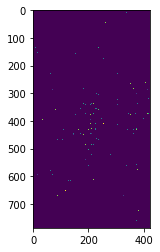

In [169]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(train_y[-120:][0], interpolation='nearest')
plt.show()

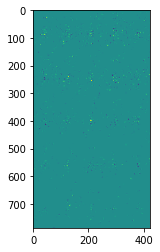

In [279]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(np.squeeze(preds2[0], axis=2)*100, interpolation='nearest')
plt.show()

## Generate prediction of new data

In [125]:
valid_no_outliers.timestamp.max()

Timestamp('2020-02-29 22:00:00')

In [34]:
train_processed_x.timestamp.unique()[-5:]

array(['2020-01-31T19:00:00.000000000', '2020-01-31T20:00:00.000000000',
       '2020-01-31T21:00:00.000000000', '2020-01-31T22:00:00.000000000',
       '2020-01-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [292]:
def generate_prediction_image_set(data, start_date=pd.Timestamp('2020-01-31T18'), end_date=pd.Timestamp('2020-01-31T22')):
    train_3d_images = []
    ground_truth = []
    three_d_image = []
    for single_date in tqdm(daterange(start_date, end_date+timedelta(hours=1)), total=len(list(daterange(start_date, end_date+timedelta(hours=1))))):
        three_d_image.append(generate_image(spec_timestamp=single_date, input_data=data))
    return three_d_image

In [293]:
last_sample = generate_prediction_image_set(train_processed_x, start_date=pd.Timestamp('2020-01-31T19'), end_date=pd.Timestamp('2020-01-31T23'))

100%|██████████| 5/5 [00:00<00:00, 11.39it/s]


In [294]:
np.array(last_sample).shape

(5, 787, 422)

In [295]:
pred = model.predict(np.expand_dims(np.array(last_sample).reshape((787, 422, -1, 1)) / float(pixels_norm*100), axis=0)) # TODO: remove *100

1/1 [==============================] - 0s 273ms/step


In [296]:
pred

array([[[[[0.31604043]],

         [[0.26833114]],

         [[0.26431614]],

         ...,

         [[0.2643202 ]],

         [[0.2677631 ]],

         [[0.320893  ]]],


        [[[0.28371507]],

         [[0.24094301]],

         [[0.23822428]],

         ...,

         [[0.23822694]],

         [[0.2411467 ]],

         [[0.2927994 ]]],


        [[[0.28091428]],

         [[0.23957999]],

         [[0.2370899 ]],

         ...,

         [[0.23709168]],

         [[0.2398877 ]],

         [[0.29114008]]],


        ...,


        [[[0.28090686]],

         [[0.23958094]],

         [[0.23709174]],

         ...,

         [[0.23709388]],

         [[0.23989236]],

         [[0.29114836]]],


        [[[0.28415346]],

         [[0.24265657]],

         [[0.23964022]],

         ...,

         [[0.23964173]],

         [[0.24296737]],

         [[0.29479375]]],


        [[[0.3381597 ]],

         [[0.31814596]],

         [[0.31511018]],

         ...,

         [[0.31511945]],

 

In [309]:
def test(start_date=pd.Timestamp('2020-02-01T01'), end_date=pd.Timestamp('2020-02-29T22'), last_sample=np.array([])):
    predictions = []
    predictions_with_ts = {}
    last_sample = np.expand_dims(np.array(last_sample).reshape((787, 422, -1, 1)) / float(pixels_norm*100), axis=0) # TODO: remove *100
    val_preds = model.predict(last_sample)
    predictions.append(val_preds)
    for ts in tqdm(daterange(start_date, end_date+timedelta(hours=1)), total=len(list(daterange(start_date, end_date+timedelta(hours=1))))):
        last_sample = last_sample[:, :, :, -4:, :]
        last_sample = np.append(last_sample, val_preds, axis=3)
        val_preds = model.predict(last_sample)
        predictions.append(val_preds)
        predictions_with_ts[ts] = val_preds
    return predictions, predictions_with_ts

In [310]:
p , p_ts = test(last_sample=last_sample)

1/1 [==============================] - 0s 223ms/step


  0%|          | 0/694 [00:00<?, ?it/s]

1/1 [==============================] - 0s 224ms/step


  0%|          | 1/694 [00:00<04:00,  2.88it/s]

1/1 [==============================] - 0s 269ms/step


  0%|          | 2/694 [00:00<04:36,  2.50it/s]

1/1 [==============================] - 0s 218ms/step


  0%|          | 3/694 [00:01<04:29,  2.57it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 4/694 [00:01<03:57,  2.90it/s]

1/1 [==============================] - 0s 184ms/step


  1%|          | 5/694 [00:01<03:37,  3.16it/s]

1/1 [==============================] - 0s 263ms/step


  1%|          | 6/694 [00:02<03:40,  3.12it/s]

1/1 [==============================] - 0s 267ms/step


  1%|          | 7/694 [00:02<03:44,  3.06it/s]

1/1 [==============================] - 0s 231ms/step


  1%|          | 8/694 [00:02<03:48,  3.00it/s]

1/1 [==============================] - 0s 183ms/step


  1%|▏         | 9/694 [00:03<03:40,  3.11it/s]

1/1 [==============================] - 0s 207ms/step


  1%|▏         | 10/694 [00:03<03:29,  3.26it/s]

1/1 [==============================] - 0s 165ms/step


  2%|▏         | 11/694 [00:03<03:22,  3.38it/s]

1/1 [==============================] - 0s 254ms/step


  2%|▏         | 12/694 [00:03<03:37,  3.14it/s]

1/1 [==============================] - 0s 221ms/step


  2%|▏         | 13/694 [00:04<03:36,  3.14it/s]

1/1 [==============================] - 0s 264ms/step


  2%|▏         | 14/694 [00:04<03:41,  3.07it/s]

1/1 [==============================] - 0s 223ms/step


  2%|▏         | 15/694 [00:04<03:33,  3.17it/s]

1/1 [==============================] - 0s 226ms/step


  2%|▏         | 16/694 [00:05<03:27,  3.27it/s]

1/1 [==============================] - 0s 297ms/step


  2%|▏         | 17/694 [00:05<03:53,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


  3%|▎         | 18/694 [00:05<03:46,  2.98it/s]

1/1 [==============================] - 0s 288ms/step


  3%|▎         | 19/694 [00:06<03:51,  2.92it/s]

1/1 [==============================] - 0s 264ms/step


  3%|▎         | 20/694 [00:06<04:13,  2.66it/s]

1/1 [==============================] - 0s 268ms/step


  3%|▎         | 21/694 [00:07<04:13,  2.65it/s]

1/1 [==============================] - 0s 312ms/step


  3%|▎         | 22/694 [00:07<04:38,  2.41it/s]

1/1 [==============================] - 0s 326ms/step


  3%|▎         | 23/694 [00:08<04:41,  2.38it/s]

1/1 [==============================] - 0s 260ms/step


  3%|▎         | 24/694 [00:08<04:27,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


  4%|▎         | 25/694 [00:08<04:32,  2.46it/s]

1/1 [==============================] - 0s 249ms/step


  4%|▎         | 26/694 [00:09<04:22,  2.55it/s]

1/1 [==============================] - 0s 238ms/step


  4%|▍         | 27/694 [00:09<04:13,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


  4%|▍         | 28/694 [00:09<04:10,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


  4%|▍         | 29/694 [00:10<04:03,  2.74it/s]

1/1 [==============================] - 0s 244ms/step


  4%|▍         | 30/694 [00:10<04:05,  2.71it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 31/694 [00:10<03:59,  2.77it/s]

1/1 [==============================] - 0s 162ms/step


  5%|▍         | 32/694 [00:11<03:51,  2.86it/s]

1/1 [==============================] - 0s 251ms/step


  5%|▍         | 33/694 [00:11<03:52,  2.85it/s]

1/1 [==============================] - 0s 206ms/step


  5%|▍         | 34/694 [00:11<03:37,  3.03it/s]

1/1 [==============================] - 0s 184ms/step


  5%|▌         | 35/694 [00:12<03:45,  2.92it/s]

1/1 [==============================] - 0s 179ms/step


  5%|▌         | 36/694 [00:12<03:49,  2.86it/s]

1/1 [==============================] - 0s 228ms/step


  5%|▌         | 37/694 [00:12<03:48,  2.88it/s]

1/1 [==============================] - 0s 218ms/step


  5%|▌         | 38/694 [00:13<03:47,  2.88it/s]

1/1 [==============================] - 0s 161ms/step


  6%|▌         | 39/694 [00:13<03:52,  2.82it/s]

1/1 [==============================] - 0s 254ms/step


  6%|▌         | 40/694 [00:14<03:58,  2.74it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 41/694 [00:14<03:47,  2.88it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▌         | 42/694 [00:14<03:53,  2.80it/s]

1/1 [==============================] - 0s 211ms/step


  6%|▌         | 43/694 [00:15<03:44,  2.90it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▋         | 44/694 [00:15<03:31,  3.07it/s]

1/1 [==============================] - 0s 163ms/step


  6%|▋         | 45/694 [00:15<03:18,  3.27it/s]

1/1 [==============================] - 0s 256ms/step


  7%|▋         | 46/694 [00:16<03:31,  3.06it/s]

1/1 [==============================] - 0s 225ms/step


  7%|▋         | 47/694 [00:16<03:43,  2.89it/s]

1/1 [==============================] - 0s 217ms/step


  7%|▋         | 48/694 [00:16<03:30,  3.07it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 49/694 [00:17<03:42,  2.90it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 50/694 [00:17<03:35,  2.99it/s]

1/1 [==============================] - 0s 258ms/step


  7%|▋         | 51/694 [00:17<03:41,  2.91it/s]

1/1 [==============================] - 0s 182ms/step


  7%|▋         | 52/694 [00:18<03:29,  3.06it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 53/694 [00:18<03:30,  3.05it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 54/694 [00:18<03:39,  2.92it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 55/694 [00:19<03:45,  2.83it/s]

1/1 [==============================] - 0s 214ms/step


  8%|▊         | 56/694 [00:19<03:48,  2.80it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 57/694 [00:19<03:56,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


  8%|▊         | 58/694 [00:20<04:14,  2.49it/s]

1/1 [==============================] - 0s 249ms/step


  9%|▊         | 59/694 [00:20<04:05,  2.58it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▊         | 60/694 [00:21<04:03,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▉         | 61/694 [00:21<04:15,  2.48it/s]

1/1 [==============================] - 0s 228ms/step


  9%|▉         | 62/694 [00:21<04:02,  2.60it/s]

1/1 [==============================] - 0s 277ms/step


  9%|▉         | 63/694 [00:22<04:06,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


  9%|▉         | 64/694 [00:22<03:57,  2.65it/s]

1/1 [==============================] - 0s 220ms/step


  9%|▉         | 65/694 [00:23<03:56,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 10%|▉         | 66/694 [00:23<03:51,  2.71it/s]

1/1 [==============================] - 0s 203ms/step


 10%|▉         | 67/694 [00:23<03:51,  2.71it/s]

1/1 [==============================] - 0s 234ms/step


 10%|▉         | 68/694 [00:24<03:59,  2.61it/s]

1/1 [==============================] - 0s 219ms/step


 10%|▉         | 69/694 [00:24<04:01,  2.59it/s]

1/1 [==============================] - 0s 198ms/step


 10%|█         | 70/694 [00:24<03:57,  2.62it/s]

1/1 [==============================] - 0s 204ms/step


 10%|█         | 71/694 [00:25<03:52,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 10%|█         | 72/694 [00:25<03:55,  2.64it/s]

1/1 [==============================] - 0s 227ms/step


 11%|█         | 73/694 [00:25<03:44,  2.77it/s]

1/1 [==============================] - 0s 231ms/step


 11%|█         | 74/694 [00:26<03:53,  2.66it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█         | 75/694 [00:26<03:34,  2.88it/s]

1/1 [==============================] - 0s 186ms/step


 11%|█         | 76/694 [00:26<03:21,  3.07it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 77/694 [00:27<03:14,  3.18it/s]

1/1 [==============================] - 0s 217ms/step


 11%|█         | 78/694 [00:27<03:24,  3.01it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█▏        | 79/694 [00:27<03:34,  2.87it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 80/694 [00:28<03:09,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


 12%|█▏        | 81/694 [00:28<03:25,  2.98it/s]

1/1 [==============================] - 0s 246ms/step


 12%|█▏        | 82/694 [00:29<03:42,  2.75it/s]

1/1 [==============================] - 0s 210ms/step


 12%|█▏        | 83/694 [00:29<03:39,  2.78it/s]

1/1 [==============================] - 0s 175ms/step


 12%|█▏        | 84/694 [00:29<03:22,  3.01it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 85/694 [00:30<03:32,  2.86it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 86/694 [00:30<03:42,  2.74it/s]

1/1 [==============================] - 0s 202ms/step


 13%|█▎        | 87/694 [00:30<03:30,  2.88it/s]

1/1 [==============================] - 0s 174ms/step


 13%|█▎        | 88/694 [00:31<03:15,  3.09it/s]

1/1 [==============================] - 0s 213ms/step


 13%|█▎        | 89/694 [00:31<03:12,  3.14it/s]

1/1 [==============================] - 0s 282ms/step


 13%|█▎        | 90/694 [00:31<03:26,  2.93it/s]

1/1 [==============================] - 0s 257ms/step


 13%|█▎        | 91/694 [00:32<03:35,  2.80it/s]

1/1 [==============================] - 0s 285ms/step


 13%|█▎        | 92/694 [00:32<03:40,  2.73it/s]

1/1 [==============================] - 0s 344ms/step


 13%|█▎        | 93/694 [00:32<03:55,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 14%|█▎        | 94/694 [00:33<03:50,  2.60it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▎        | 95/694 [00:33<03:55,  2.55it/s]

1/1 [==============================] - 0s 275ms/step


 14%|█▍        | 96/694 [00:34<04:04,  2.45it/s]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 97/694 [00:34<03:53,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▍        | 98/694 [00:34<03:46,  2.63it/s]

1/1 [==============================] - 0s 272ms/step


 14%|█▍        | 99/694 [00:35<03:45,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 14%|█▍        | 100/694 [00:35<03:41,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 15%|█▍        | 101/694 [00:36<03:45,  2.63it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▍        | 102/694 [00:36<03:41,  2.67it/s]

1/1 [==============================] - 0s 232ms/step


 15%|█▍        | 103/694 [00:36<03:51,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▍        | 104/694 [00:37<04:02,  2.43it/s]

1/1 [==============================] - 0s 224ms/step


 15%|█▌        | 105/694 [00:37<03:46,  2.60it/s]

1/1 [==============================] - 0s 283ms/step


 15%|█▌        | 106/694 [00:37<03:48,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 15%|█▌        | 107/694 [00:38<03:32,  2.76it/s]

1/1 [==============================] - 0s 226ms/step


 16%|█▌        | 108/694 [00:38<03:22,  2.90it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▌        | 109/694 [00:38<03:25,  2.85it/s]

1/1 [==============================] - 0s 228ms/step


 16%|█▌        | 110/694 [00:39<03:25,  2.84it/s]

1/1 [==============================] - 0s 181ms/step


 16%|█▌        | 111/694 [00:39<03:12,  3.03it/s]

1/1 [==============================] - 0s 208ms/step


 16%|█▌        | 112/694 [00:39<03:08,  3.08it/s]

1/1 [==============================] - 0s 253ms/step


 16%|█▋        | 113/694 [00:40<03:18,  2.93it/s]

1/1 [==============================] - 0s 251ms/step


 16%|█▋        | 114/694 [00:40<03:28,  2.78it/s]

1/1 [==============================] - 0s 217ms/step


 17%|█▋        | 115/694 [00:41<03:22,  2.86it/s]

1/1 [==============================] - 0s 235ms/step


 17%|█▋        | 116/694 [00:41<03:14,  2.97it/s]

1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 117/694 [00:41<03:14,  2.97it/s]

1/1 [==============================] - 0s 271ms/step


 17%|█▋        | 118/694 [00:42<03:19,  2.88it/s]

1/1 [==============================] - 0s 197ms/step


 17%|█▋        | 119/694 [00:42<03:14,  2.96it/s]

1/1 [==============================] - 0s 249ms/step


 17%|█▋        | 120/694 [00:42<03:16,  2.92it/s]

1/1 [==============================] - 0s 303ms/step


 17%|█▋        | 121/694 [00:43<03:25,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


 18%|█▊        | 122/694 [00:43<03:21,  2.83it/s]

1/1 [==============================] - 0s 200ms/step


 18%|█▊        | 123/694 [00:43<03:17,  2.90it/s]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 124/694 [00:44<02:58,  3.19it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 125/694 [00:44<02:44,  3.46it/s]

1/1 [==============================] - 0s 258ms/step


 18%|█▊        | 126/694 [00:44<02:50,  3.33it/s]

1/1 [==============================] - 0s 160ms/step


 18%|█▊        | 127/694 [00:44<02:43,  3.46it/s]

1/1 [==============================] - 0s 237ms/step


 18%|█▊        | 128/694 [00:45<02:53,  3.25it/s]

1/1 [==============================] - 0s 187ms/step


 19%|█▊        | 129/694 [00:45<02:54,  3.23it/s]

1/1 [==============================] - 0s 297ms/step


 19%|█▊        | 130/694 [00:45<03:08,  3.00it/s]

1/1 [==============================] - 0s 300ms/step


 19%|█▉        | 131/694 [00:46<03:19,  2.82it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 132/694 [00:46<03:29,  2.69it/s]

1/1 [==============================] - 0s 260ms/step


 19%|█▉        | 133/694 [00:47<03:39,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 19%|█▉        | 134/694 [00:47<03:30,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 19%|█▉        | 135/694 [00:47<03:25,  2.72it/s]

1/1 [==============================] - 0s 230ms/step


 20%|█▉        | 136/694 [00:48<03:22,  2.75it/s]

1/1 [==============================] - 0s 192ms/step


 20%|█▉        | 137/694 [00:48<03:27,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 20%|█▉        | 138/694 [00:48<03:34,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 20%|██        | 139/694 [00:49<03:36,  2.56it/s]

1/1 [==============================] - 0s 331ms/step


 20%|██        | 140/694 [00:49<03:42,  2.49it/s]

1/1 [==============================] - 0s 281ms/step


 20%|██        | 141/694 [00:50<03:34,  2.57it/s]

1/1 [==============================] - 0s 239ms/step


 20%|██        | 142/694 [00:50<03:23,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 21%|██        | 143/694 [00:50<03:19,  2.76it/s]

1/1 [==============================] - 0s 221ms/step


 21%|██        | 144/694 [00:51<03:07,  2.93it/s]

1/1 [==============================] - 0s 266ms/step


 21%|██        | 145/694 [00:51<03:06,  2.94it/s]

1/1 [==============================] - 0s 267ms/step


 21%|██        | 146/694 [00:51<03:07,  2.92it/s]

1/1 [==============================] - 0s 226ms/step


 21%|██        | 147/694 [00:52<03:01,  3.01it/s]

1/1 [==============================] - 0s 181ms/step


 21%|██▏       | 148/694 [00:52<02:49,  3.22it/s]

1/1 [==============================] - 0s 207ms/step


 21%|██▏       | 149/694 [00:52<02:47,  3.26it/s]

1/1 [==============================] - 0s 213ms/step


 22%|██▏       | 150/694 [00:52<02:48,  3.23it/s]

1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 151/694 [00:53<02:40,  3.37it/s]

1/1 [==============================] - 0s 241ms/step


 22%|██▏       | 152/694 [00:53<02:48,  3.22it/s]

1/1 [==============================] - 0s 255ms/step


 22%|██▏       | 153/694 [00:53<03:00,  2.99it/s]

1/1 [==============================] - 0s 176ms/step


 22%|██▏       | 154/694 [00:54<02:57,  3.04it/s]

1/1 [==============================] - 0s 224ms/step


 22%|██▏       | 155/694 [00:54<02:57,  3.04it/s]

1/1 [==============================] - 0s 270ms/step


 22%|██▏       | 156/694 [00:55<03:04,  2.91it/s]

1/1 [==============================] - 0s 276ms/step


 23%|██▎       | 157/694 [00:55<03:12,  2.78it/s]

1/1 [==============================] - 0s 182ms/step


 23%|██▎       | 158/694 [00:55<02:56,  3.04it/s]

1/1 [==============================] - 0s 128ms/step


 23%|██▎       | 159/694 [00:55<02:41,  3.31it/s]

1/1 [==============================] - 0s 268ms/step


 23%|██▎       | 160/694 [00:56<02:51,  3.12it/s]

1/1 [==============================] - 0s 264ms/step


 23%|██▎       | 161/694 [00:56<02:58,  2.98it/s]

1/1 [==============================] - 0s 212ms/step


 23%|██▎       | 162/694 [00:56<02:56,  3.02it/s]

1/1 [==============================] - 0s 218ms/step


 23%|██▎       | 163/694 [00:57<03:02,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 24%|██▎       | 164/694 [00:57<03:04,  2.87it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▍       | 165/694 [00:58<03:08,  2.81it/s]

1/1 [==============================] - 0s 234ms/step


 24%|██▍       | 166/694 [00:58<03:03,  2.88it/s]

1/1 [==============================] - 0s 164ms/step


 24%|██▍       | 167/694 [00:58<02:48,  3.12it/s]

1/1 [==============================] - 0s 141ms/step


 24%|██▍       | 168/694 [00:58<02:30,  3.50it/s]

1/1 [==============================] - 0s 132ms/step


 24%|██▍       | 169/694 [00:59<02:17,  3.82it/s]

1/1 [==============================] - 0s 210ms/step


 24%|██▍       | 170/694 [00:59<02:25,  3.61it/s]

1/1 [==============================] - 0s 201ms/step


 25%|██▍       | 171/694 [00:59<02:39,  3.28it/s]

1/1 [==============================] - 0s 177ms/step


 25%|██▍       | 172/694 [01:00<02:48,  3.09it/s]

1/1 [==============================] - 0s 181ms/step


 25%|██▍       | 173/694 [01:00<02:40,  3.25it/s]

1/1 [==============================] - 0s 211ms/step


 25%|██▌       | 174/694 [01:00<02:38,  3.28it/s]

1/1 [==============================] - 0s 281ms/step


 25%|██▌       | 175/694 [01:01<02:51,  3.02it/s]

1/1 [==============================] - 0s 290ms/step


 25%|██▌       | 176/694 [01:01<03:05,  2.79it/s]

1/1 [==============================] - 0s 300ms/step


 26%|██▌       | 177/694 [01:01<03:17,  2.61it/s]

1/1 [==============================] - 0s 203ms/step


 26%|██▌       | 178/694 [01:02<03:02,  2.83it/s]

1/1 [==============================] - 0s 271ms/step


 26%|██▌       | 179/694 [01:02<03:05,  2.77it/s]

1/1 [==============================] - 0s 278ms/step


 26%|██▌       | 180/694 [01:02<03:04,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


 26%|██▌       | 181/694 [01:03<03:02,  2.81it/s]

1/1 [==============================] - 0s 264ms/step


 26%|██▌       | 182/694 [01:03<02:58,  2.86it/s]

1/1 [==============================] - 0s 223ms/step


 26%|██▋       | 183/694 [01:03<02:51,  2.98it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 184/694 [01:04<02:53,  2.94it/s]

1/1 [==============================] - 0s 315ms/step


 27%|██▋       | 185/694 [01:04<03:00,  2.81it/s]

1/1 [==============================] - 0s 306ms/step


 27%|██▋       | 186/694 [01:05<03:06,  2.72it/s]

1/1 [==============================] - 0s 286ms/step


 27%|██▋       | 187/694 [01:05<03:11,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 27%|██▋       | 188/694 [01:05<03:08,  2.68it/s]

1/1 [==============================] - 0s 221ms/step


 27%|██▋       | 189/694 [01:06<02:56,  2.85it/s]

1/1 [==============================] - 0s 208ms/step


 27%|██▋       | 190/694 [01:06<02:45,  3.04it/s]

1/1 [==============================] - 0s 322ms/step


 28%|██▊       | 191/694 [01:06<03:00,  2.78it/s]

1/1 [==============================] - 0s 220ms/step


 28%|██▊       | 192/694 [01:07<02:55,  2.86it/s]

1/1 [==============================] - 0s 225ms/step


 28%|██▊       | 193/694 [01:07<02:48,  2.97it/s]

1/1 [==============================] - 0s 197ms/step


 28%|██▊       | 194/694 [01:07<02:39,  3.13it/s]

1/1 [==============================] - 0s 244ms/step


 28%|██▊       | 195/694 [01:08<02:40,  3.11it/s]

1/1 [==============================] - 0s 214ms/step


 28%|██▊       | 196/694 [01:08<02:46,  2.99it/s]

1/1 [==============================] - 0s 275ms/step


 28%|██▊       | 197/694 [01:08<02:52,  2.89it/s]

1/1 [==============================] - 0s 195ms/step


 29%|██▊       | 198/694 [01:09<02:56,  2.81it/s]

1/1 [==============================] - 0s 247ms/step


 29%|██▊       | 199/694 [01:09<02:55,  2.81it/s]

1/1 [==============================] - 0s 160ms/step


 29%|██▉       | 200/694 [01:09<02:39,  3.09it/s]

1/1 [==============================] - 0s 216ms/step


 29%|██▉       | 201/694 [01:10<02:41,  3.06it/s]

1/1 [==============================] - 0s 208ms/step


 29%|██▉       | 202/694 [01:10<02:32,  3.22it/s]

1/1 [==============================] - 0s 209ms/step


 29%|██▉       | 203/694 [01:10<02:33,  3.21it/s]

1/1 [==============================] - 0s 230ms/step


 29%|██▉       | 204/694 [01:11<02:36,  3.13it/s]

1/1 [==============================] - 0s 206ms/step


 30%|██▉       | 205/694 [01:11<02:33,  3.18it/s]

1/1 [==============================] - 0s 144ms/step


 30%|██▉       | 206/694 [01:11<02:22,  3.42it/s]

1/1 [==============================] - 0s 237ms/step


 30%|██▉       | 207/694 [01:11<02:28,  3.29it/s]

1/1 [==============================] - 0s 228ms/step


 30%|██▉       | 208/694 [01:12<02:37,  3.09it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███       | 209/694 [01:12<02:41,  3.01it/s]

1/1 [==============================] - 0s 195ms/step


 30%|███       | 210/694 [01:13<02:47,  2.88it/s]

1/1 [==============================] - 0s 202ms/step


 30%|███       | 211/694 [01:13<02:51,  2.82it/s]

1/1 [==============================] - 0s 221ms/step


 31%|███       | 212/694 [01:13<02:47,  2.88it/s]

1/1 [==============================] - 0s 180ms/step


 31%|███       | 213/694 [01:14<02:38,  3.04it/s]

1/1 [==============================] - 0s 202ms/step


 31%|███       | 214/694 [01:14<02:32,  3.14it/s]

1/1 [==============================] - 0s 196ms/step


 31%|███       | 215/694 [01:14<02:28,  3.22it/s]

1/1 [==============================] - 0s 303ms/step


 31%|███       | 216/694 [01:15<02:40,  2.98it/s]

1/1 [==============================] - 0s 243ms/step


 31%|███▏      | 217/694 [01:15<02:41,  2.96it/s]

1/1 [==============================] - 0s 238ms/step


 31%|███▏      | 218/694 [01:15<02:40,  2.96it/s]

1/1 [==============================] - 0s 184ms/step


 32%|███▏      | 219/694 [01:16<02:37,  3.02it/s]

1/1 [==============================] - 0s 169ms/step


 32%|███▏      | 220/694 [01:16<02:41,  2.93it/s]

1/1 [==============================] - 0s 281ms/step


 32%|███▏      | 221/694 [01:16<02:50,  2.77it/s]

1/1 [==============================] - 0s 317ms/step


 32%|███▏      | 222/694 [01:17<02:57,  2.65it/s]

1/1 [==============================] - 0s 291ms/step


 32%|███▏      | 223/694 [01:17<03:05,  2.54it/s]

1/1 [==============================] - 0s 221ms/step


 32%|███▏      | 224/694 [01:17<02:58,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 32%|███▏      | 225/694 [01:18<02:58,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 33%|███▎      | 226/694 [01:18<02:56,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 33%|███▎      | 227/694 [01:19<02:55,  2.66it/s]

1/1 [==============================] - 0s 228ms/step


 33%|███▎      | 228/694 [01:19<03:01,  2.56it/s]

1/1 [==============================] - 0s 279ms/step


 33%|███▎      | 229/694 [01:19<03:10,  2.44it/s]

1/1 [==============================] - 0s 384ms/step


 33%|███▎      | 230/694 [01:20<03:22,  2.29it/s]

1/1 [==============================] - 0s 232ms/step


 33%|███▎      | 231/694 [01:21<05:25,  1.42it/s]

1/1 [==============================] - 0s 266ms/step


 33%|███▎      | 232/694 [01:22<04:37,  1.66it/s]

1/1 [==============================] - 0s 269ms/step


 34%|███▎      | 233/694 [01:22<04:10,  1.84it/s]

1/1 [==============================] - 0s 235ms/step


 34%|███▎      | 234/694 [01:22<03:49,  2.01it/s]

1/1 [==============================] - 0s 197ms/step


 34%|███▍      | 235/694 [01:23<03:23,  2.25it/s]

1/1 [==============================] - 0s 234ms/step


 34%|███▍      | 236/694 [01:23<03:13,  2.37it/s]

1/1 [==============================] - 0s 174ms/step


 34%|███▍      | 237/694 [01:23<02:49,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 34%|███▍      | 238/694 [01:24<02:44,  2.77it/s]

1/1 [==============================] - 0s 182ms/step


 34%|███▍      | 239/694 [01:24<02:41,  2.82it/s]

1/1 [==============================] - 0s 275ms/step


 35%|███▍      | 240/694 [01:25<02:58,  2.55it/s]

1/1 [==============================] - 0s 190ms/step


 35%|███▍      | 241/694 [01:25<02:50,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 35%|███▍      | 242/694 [01:25<02:45,  2.73it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███▌      | 243/694 [01:26<02:38,  2.85it/s]

1/1 [==============================] - 0s 210ms/step


 35%|███▌      | 244/694 [01:26<02:36,  2.88it/s]

1/1 [==============================] - 0s 298ms/step


 35%|███▌      | 245/694 [01:26<02:50,  2.63it/s]

1/1 [==============================] - 0s 292ms/step


 35%|███▌      | 246/694 [01:27<02:56,  2.54it/s]

1/1 [==============================] - 0s 163ms/step


 36%|███▌      | 247/694 [01:27<02:39,  2.80it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 248/694 [01:27<02:20,  3.18it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▌      | 249/694 [01:28<02:09,  3.43it/s]

1/1 [==============================] - 0s 201ms/step


 36%|███▌      | 250/694 [01:28<02:07,  3.49it/s]

1/1 [==============================] - 0s 331ms/step


 36%|███▌      | 251/694 [01:28<02:26,  3.03it/s]

1/1 [==============================] - 0s 254ms/step


 36%|███▋      | 252/694 [01:29<02:22,  3.09it/s]

1/1 [==============================] - 0s 226ms/step


 36%|███▋      | 253/694 [01:29<02:23,  3.08it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 254/694 [01:29<02:13,  3.30it/s]

1/1 [==============================] - 0s 340ms/step


 37%|███▋      | 255/694 [01:30<02:35,  2.83it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 256/694 [01:30<02:44,  2.66it/s]

1/1 [==============================] - 0s 208ms/step


 37%|███▋      | 257/694 [01:30<02:48,  2.60it/s]

1/1 [==============================] - 0s 198ms/step


 37%|███▋      | 258/694 [01:31<02:49,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 259/694 [01:31<02:58,  2.44it/s]

1/1 [==============================] - 0s 233ms/step


 37%|███▋      | 260/694 [01:32<02:54,  2.49it/s]

1/1 [==============================] - 0s 316ms/step


 38%|███▊      | 261/694 [01:32<02:58,  2.43it/s]

1/1 [==============================] - 0s 234ms/step


 38%|███▊      | 262/694 [01:33<03:01,  2.38it/s]

1/1 [==============================] - 0s 276ms/step


 38%|███▊      | 263/694 [01:33<02:59,  2.40it/s]

1/1 [==============================] - 0s 249ms/step


 38%|███▊      | 264/694 [01:33<02:50,  2.52it/s]

1/1 [==============================] - 0s 291ms/step


 38%|███▊      | 265/694 [01:34<02:48,  2.54it/s]

1/1 [==============================] - 0s 316ms/step


 38%|███▊      | 266/694 [01:34<02:46,  2.56it/s]

1/1 [==============================] - 0s 333ms/step


 38%|███▊      | 267/694 [01:34<02:53,  2.46it/s]

1/1 [==============================] - 0s 331ms/step


 39%|███▊      | 268/694 [01:35<03:03,  2.32it/s]

1/1 [==============================] - 0s 277ms/step


 39%|███▉      | 269/694 [01:35<03:01,  2.34it/s]

1/1 [==============================] - 0s 198ms/step


 39%|███▉      | 270/694 [01:36<02:44,  2.57it/s]

1/1 [==============================] - 0s 217ms/step


 39%|███▉      | 271/694 [01:36<02:44,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 39%|███▉      | 272/694 [01:37<02:47,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 39%|███▉      | 273/694 [01:37<02:39,  2.65it/s]

1/1 [==============================] - 0s 331ms/step


 39%|███▉      | 274/694 [01:37<02:43,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 40%|███▉      | 275/694 [01:38<02:44,  2.55it/s]

1/1 [==============================] - 0s 294ms/step


 40%|███▉      | 276/694 [01:38<02:47,  2.49it/s]

1/1 [==============================] - 0s 154ms/step


 40%|███▉      | 277/694 [01:38<02:39,  2.61it/s]

1/1 [==============================] - 0s 201ms/step


 40%|████      | 278/694 [01:39<02:36,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 40%|████      | 279/694 [01:39<02:34,  2.68it/s]

1/1 [==============================] - 0s 277ms/step


 40%|████      | 280/694 [01:40<02:42,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


 40%|████      | 281/694 [01:40<02:36,  2.63it/s]

1/1 [==============================] - 0s 276ms/step


 41%|████      | 282/694 [01:40<02:42,  2.53it/s]

1/1 [==============================] - 0s 236ms/step


 41%|████      | 283/694 [01:41<02:34,  2.66it/s]

1/1 [==============================] - 0s 202ms/step


 41%|████      | 284/694 [01:41<02:30,  2.73it/s]

1/1 [==============================] - 0s 188ms/step


 41%|████      | 285/694 [01:41<02:20,  2.91it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████      | 286/694 [01:42<02:20,  2.90it/s]

1/1 [==============================] - 0s 163ms/step


 41%|████▏     | 287/694 [01:42<02:25,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 41%|████▏     | 288/694 [01:42<02:23,  2.82it/s]

1/1 [==============================] - 0s 211ms/step


 42%|████▏     | 289/694 [01:43<02:21,  2.86it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 290/694 [01:43<02:24,  2.79it/s]

1/1 [==============================] - 0s 241ms/step


 42%|████▏     | 291/694 [01:44<02:33,  2.63it/s]

1/1 [==============================] - 0s 178ms/step


 42%|████▏     | 292/694 [01:44<02:30,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 42%|████▏     | 293/694 [01:44<02:35,  2.58it/s]

1/1 [==============================] - 0s 296ms/step


 42%|████▏     | 294/694 [01:45<02:35,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 43%|████▎     | 295/694 [01:45<02:34,  2.57it/s]

1/1 [==============================] - 0s 174ms/step


 43%|████▎     | 296/694 [01:45<02:31,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 43%|████▎     | 297/694 [01:46<02:41,  2.45it/s]

1/1 [==============================] - 0s 287ms/step


 43%|████▎     | 298/694 [01:46<02:43,  2.42it/s]

1/1 [==============================] - 0s 250ms/step


 43%|████▎     | 299/694 [01:47<02:46,  2.37it/s]

1/1 [==============================] - 0s 257ms/step


 43%|████▎     | 300/694 [01:47<02:40,  2.45it/s]

1/1 [==============================] - 0s 221ms/step


 43%|████▎     | 301/694 [01:48<02:38,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▎     | 302/694 [01:48<02:40,  2.45it/s]

1/1 [==============================] - 0s 267ms/step


 44%|████▎     | 303/694 [01:48<02:38,  2.47it/s]

1/1 [==============================] - 0s 200ms/step


 44%|████▍     | 304/694 [01:49<02:24,  2.69it/s]

1/1 [==============================] - 0s 326ms/step


 44%|████▍     | 305/694 [01:49<02:30,  2.59it/s]

1/1 [==============================] - 0s 280ms/step


 44%|████▍     | 306/694 [01:50<02:32,  2.55it/s]

1/1 [==============================] - 0s 315ms/step


 44%|████▍     | 307/694 [01:50<02:37,  2.46it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▍     | 308/694 [01:50<02:32,  2.53it/s]

1/1 [==============================] - 0s 174ms/step


 45%|████▍     | 309/694 [01:51<02:15,  2.84it/s]

1/1 [==============================] - 0s 211ms/step


 45%|████▍     | 310/694 [01:51<02:07,  3.01it/s]

1/1 [==============================] - 0s 283ms/step


 45%|████▍     | 311/694 [01:51<02:10,  2.93it/s]

1/1 [==============================] - 0s 240ms/step


 45%|████▍     | 312/694 [01:52<02:08,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


 45%|████▌     | 313/694 [01:52<02:08,  2.97it/s]

1/1 [==============================] - 0s 180ms/step


 45%|████▌     | 314/694 [01:52<01:58,  3.21it/s]

1/1 [==============================] - 0s 159ms/step


 45%|████▌     | 315/694 [01:52<01:49,  3.46it/s]

1/1 [==============================] - 0s 253ms/step


 46%|████▌     | 316/694 [01:53<01:54,  3.29it/s]

1/1 [==============================] - 0s 244ms/step


 46%|████▌     | 317/694 [01:53<02:01,  3.11it/s]

1/1 [==============================] - 0s 212ms/step


 46%|████▌     | 318/694 [01:53<01:59,  3.14it/s]

1/1 [==============================] - 0s 216ms/step


 46%|████▌     | 319/694 [01:54<02:06,  2.97it/s]

1/1 [==============================] - 0s 257ms/step


 46%|████▌     | 320/694 [01:54<02:06,  2.95it/s]

1/1 [==============================] - 0s 268ms/step


 46%|████▋     | 321/694 [01:54<02:08,  2.91it/s]

1/1 [==============================] - 0s 286ms/step


 46%|████▋     | 322/694 [01:55<02:11,  2.84it/s]

1/1 [==============================] - 0s 215ms/step


 47%|████▋     | 323/694 [01:55<02:05,  2.94it/s]

1/1 [==============================] - 0s 168ms/step


 47%|████▋     | 324/694 [01:55<01:59,  3.09it/s]

1/1 [==============================] - 0s 280ms/step


 47%|████▋     | 325/694 [01:56<02:03,  2.98it/s]

1/1 [==============================] - 0s 260ms/step


 47%|████▋     | 326/694 [01:56<02:08,  2.86it/s]

1/1 [==============================] - 0s 268ms/step


 47%|████▋     | 327/694 [01:57<02:10,  2.81it/s]

1/1 [==============================] - 0s 193ms/step


 47%|████▋     | 328/694 [01:57<02:02,  2.99it/s]

1/1 [==============================] - 0s 252ms/step


 47%|████▋     | 329/694 [01:57<02:03,  2.94it/s]

1/1 [==============================] - 0s 327ms/step


 48%|████▊     | 330/694 [01:58<02:14,  2.71it/s]

1/1 [==============================] - 0s 320ms/step


 48%|████▊     | 331/694 [01:58<02:21,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 48%|████▊     | 332/694 [01:59<02:27,  2.45it/s]

1/1 [==============================] - 0s 217ms/step


 48%|████▊     | 333/694 [01:59<02:25,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 48%|████▊     | 334/694 [01:59<02:26,  2.45it/s]

1/1 [==============================] - 0s 234ms/step


 48%|████▊     | 335/694 [02:00<02:28,  2.42it/s]

1/1 [==============================] - 0s 212ms/step


 48%|████▊     | 336/694 [02:00<02:24,  2.47it/s]

1/1 [==============================] - 0s 323ms/step


 49%|████▊     | 337/694 [02:01<02:34,  2.31it/s]

1/1 [==============================] - 0s 223ms/step


 49%|████▊     | 338/694 [02:01<02:28,  2.40it/s]

1/1 [==============================] - 0s 294ms/step


 49%|████▉     | 339/694 [02:01<02:26,  2.42it/s]

1/1 [==============================] - 0s 252ms/step


 49%|████▉     | 340/694 [02:02<02:26,  2.42it/s]

1/1 [==============================] - 0s 190ms/step


 49%|████▉     | 341/694 [02:02<02:20,  2.51it/s]

1/1 [==============================] - 0s 274ms/step


 49%|████▉     | 342/694 [02:03<02:21,  2.49it/s]

1/1 [==============================] - 0s 233ms/step


 49%|████▉     | 343/694 [02:03<02:13,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 50%|████▉     | 344/694 [02:03<02:13,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 50%|████▉     | 345/694 [02:04<02:12,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 50%|████▉     | 346/694 [02:04<02:16,  2.55it/s]

1/1 [==============================] - 0s 172ms/step


 50%|█████     | 347/694 [02:04<02:01,  2.85it/s]

1/1 [==============================] - 0s 188ms/step


 50%|█████     | 348/694 [02:05<01:55,  3.00it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 349/694 [02:05<02:01,  2.85it/s]

1/1 [==============================] - 0s 243ms/step


 50%|█████     | 350/694 [02:05<02:00,  2.86it/s]

1/1 [==============================] - 0s 172ms/step


 51%|█████     | 351/694 [02:06<01:51,  3.07it/s]

1/1 [==============================] - 0s 231ms/step


 51%|█████     | 352/694 [02:06<01:51,  3.08it/s]

1/1 [==============================] - 0s 245ms/step


 51%|█████     | 353/694 [02:06<02:00,  2.82it/s]

1/1 [==============================] - 0s 225ms/step


 51%|█████     | 354/694 [02:07<01:58,  2.87it/s]

1/1 [==============================] - 0s 213ms/step


 51%|█████     | 355/694 [02:07<01:59,  2.83it/s]

1/1 [==============================] - 0s 194ms/step


 51%|█████▏    | 356/694 [02:07<01:58,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


 51%|█████▏    | 357/694 [02:08<01:55,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


 52%|█████▏    | 358/694 [02:08<01:53,  2.97it/s]

1/1 [==============================] - 0s 202ms/step


 52%|█████▏    | 359/694 [02:08<01:53,  2.95it/s]

1/1 [==============================] - 0s 207ms/step


 52%|█████▏    | 360/694 [02:09<01:59,  2.80it/s]

1/1 [==============================] - 0s 230ms/step


 52%|█████▏    | 361/694 [02:09<01:53,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


 52%|█████▏    | 362/694 [02:09<01:45,  3.15it/s]

1/1 [==============================] - 0s 235ms/step


 52%|█████▏    | 363/694 [02:10<01:44,  3.18it/s]

1/1 [==============================] - 0s 192ms/step


 52%|█████▏    | 364/694 [02:10<01:41,  3.26it/s]

1/1 [==============================] - 0s 217ms/step


 53%|█████▎    | 365/694 [02:10<01:39,  3.30it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 366/694 [02:11<01:31,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████▎    | 367/694 [02:11<01:21,  4.00it/s]

1/1 [==============================] - 0s 198ms/step


 53%|█████▎    | 368/694 [02:11<01:23,  3.91it/s]

1/1 [==============================] - 0s 260ms/step


 53%|█████▎    | 369/694 [02:11<01:30,  3.58it/s]

1/1 [==============================] - 0s 198ms/step


 53%|█████▎    | 370/694 [02:12<01:26,  3.72it/s]

1/1 [==============================] - 0s 216ms/step


 53%|█████▎    | 371/694 [02:12<01:28,  3.65it/s]

1/1 [==============================] - 0s 193ms/step


 54%|█████▎    | 372/694 [02:12<01:26,  3.71it/s]

1/1 [==============================] - 0s 219ms/step


 54%|█████▎    | 373/694 [02:12<01:28,  3.62it/s]

1/1 [==============================] - 0s 302ms/step


 54%|█████▍    | 374/694 [02:13<01:39,  3.21it/s]

1/1 [==============================] - 0s 284ms/step


 54%|█████▍    | 375/694 [02:13<01:44,  3.07it/s]

1/1 [==============================] - 0s 222ms/step


 54%|█████▍    | 376/694 [02:13<01:41,  3.15it/s]

1/1 [==============================] - 0s 281ms/step


 54%|█████▍    | 377/694 [02:14<01:43,  3.07it/s]

1/1 [==============================] - 0s 223ms/step


 54%|█████▍    | 378/694 [02:14<01:40,  3.15it/s]

1/1 [==============================] - 0s 262ms/step


 55%|█████▍    | 379/694 [02:14<01:42,  3.07it/s]

1/1 [==============================] - 0s 259ms/step


 55%|█████▍    | 380/694 [02:15<01:44,  3.00it/s]

1/1 [==============================] - 0s 208ms/step


 55%|█████▍    | 381/694 [02:15<01:39,  3.15it/s]

1/1 [==============================] - 0s 331ms/step


 55%|█████▌    | 382/694 [02:16<01:48,  2.87it/s]

1/1 [==============================] - 0s 243ms/step


 55%|█████▌    | 383/694 [02:16<01:45,  2.95it/s]

1/1 [==============================] - 0s 259ms/step


 55%|█████▌    | 384/694 [02:16<01:55,  2.68it/s]

1/1 [==============================] - 0s 333ms/step


 55%|█████▌    | 385/694 [02:17<01:59,  2.58it/s]

1/1 [==============================] - 0s 279ms/step


 56%|█████▌    | 386/694 [02:17<01:56,  2.65it/s]

1/1 [==============================] - 0s 220ms/step


 56%|█████▌    | 387/694 [02:17<01:48,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


 56%|█████▌    | 388/694 [02:18<01:45,  2.90it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▌    | 389/694 [02:18<01:43,  2.96it/s]

1/1 [==============================] - 0s 243ms/step


 56%|█████▌    | 390/694 [02:18<01:40,  3.03it/s]

1/1 [==============================] - 0s 332ms/step


 56%|█████▋    | 391/694 [02:19<01:47,  2.83it/s]

1/1 [==============================] - 0s 208ms/step


 56%|█████▋    | 392/694 [02:19<01:39,  3.03it/s]

1/1 [==============================] - 0s 268ms/step


 57%|█████▋    | 393/694 [02:19<01:42,  2.95it/s]

1/1 [==============================] - 0s 294ms/step


 57%|█████▋    | 394/694 [02:20<01:45,  2.84it/s]

1/1 [==============================] - 0s 160ms/step


 57%|█████▋    | 395/694 [02:20<01:36,  3.11it/s]

1/1 [==============================] - 0s 219ms/step


 57%|█████▋    | 396/694 [02:20<01:32,  3.21it/s]

1/1 [==============================] - 0s 255ms/step


 57%|█████▋    | 397/694 [02:21<01:33,  3.17it/s]

1/1 [==============================] - 0s 210ms/step


 57%|█████▋    | 398/694 [02:21<01:30,  3.26it/s]

1/1 [==============================] - 0s 319ms/step


 57%|█████▋    | 399/694 [02:21<01:46,  2.76it/s]

1/1 [==============================] - 0s 169ms/step


 58%|█████▊    | 400/694 [02:22<01:37,  3.01it/s]

1/1 [==============================] - 0s 197ms/step


 58%|█████▊    | 401/694 [02:22<01:34,  3.09it/s]

1/1 [==============================] - 0s 224ms/step


 58%|█████▊    | 402/694 [02:22<01:39,  2.94it/s]

1/1 [==============================] - 0s 246ms/step


 58%|█████▊    | 403/694 [02:23<01:44,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


 58%|█████▊    | 404/694 [02:23<01:46,  2.73it/s]

1/1 [==============================] - 0s 175ms/step


 58%|█████▊    | 405/694 [02:23<01:34,  3.07it/s]

1/1 [==============================] - 0s 159ms/step


 59%|█████▊    | 406/694 [02:24<01:26,  3.31it/s]

1/1 [==============================] - 0s 242ms/step


 59%|█████▊    | 407/694 [02:24<01:26,  3.33it/s]

1/1 [==============================] - 0s 255ms/step


 59%|█████▉    | 408/694 [02:24<01:30,  3.17it/s]

1/1 [==============================] - 0s 307ms/step


 59%|█████▉    | 409/694 [02:25<01:35,  3.00it/s]

1/1 [==============================] - 0s 238ms/step


 59%|█████▉    | 410/694 [02:25<01:38,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▉    | 411/694 [02:25<01:38,  2.88it/s]

1/1 [==============================] - 0s 242ms/step


 59%|█████▉    | 412/694 [02:26<01:42,  2.75it/s]

1/1 [==============================] - 0s 193ms/step


 60%|█████▉    | 413/694 [02:26<01:38,  2.86it/s]

1/1 [==============================] - 0s 178ms/step


 60%|█████▉    | 414/694 [02:26<01:32,  3.02it/s]

1/1 [==============================] - 0s 197ms/step


 60%|█████▉    | 415/694 [02:27<01:33,  2.98it/s]

1/1 [==============================] - 0s 254ms/step


 60%|█████▉    | 416/694 [02:27<01:36,  2.89it/s]

1/1 [==============================] - 0s 257ms/step


 60%|██████    | 417/694 [02:27<01:35,  2.89it/s]

1/1 [==============================] - 0s 190ms/step


 60%|██████    | 418/694 [02:28<01:30,  3.06it/s]

1/1 [==============================] - 0s 220ms/step


 60%|██████    | 419/694 [02:28<01:30,  3.05it/s]

1/1 [==============================] - 0s 210ms/step


 61%|██████    | 420/694 [02:28<01:31,  2.99it/s]

1/1 [==============================] - 0s 162ms/step


 61%|██████    | 421/694 [02:29<01:32,  2.96it/s]

1/1 [==============================] - 0s 211ms/step


 61%|██████    | 422/694 [02:29<01:29,  3.05it/s]

1/1 [==============================] - 0s 189ms/step


 61%|██████    | 423/694 [02:29<01:32,  2.92it/s]

1/1 [==============================] - 0s 227ms/step


 61%|██████    | 424/694 [02:30<01:30,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 61%|██████    | 425/694 [02:30<01:29,  3.00it/s]

1/1 [==============================] - 0s 210ms/step


 61%|██████▏   | 426/694 [02:30<01:28,  3.04it/s]

1/1 [==============================] - 0s 200ms/step


 62%|██████▏   | 427/694 [02:31<01:22,  3.22it/s]

1/1 [==============================] - 0s 228ms/step


 62%|██████▏   | 428/694 [02:31<01:22,  3.21it/s]

1/1 [==============================] - 0s 222ms/step


 62%|██████▏   | 429/694 [02:31<01:21,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


 62%|██████▏   | 430/694 [02:32<01:24,  3.14it/s]

1/1 [==============================] - 0s 252ms/step


 62%|██████▏   | 431/694 [02:32<01:26,  3.03it/s]

1/1 [==============================] - 0s 291ms/step


 62%|██████▏   | 432/694 [02:32<01:36,  2.72it/s]

1/1 [==============================] - 0s 267ms/step


 62%|██████▏   | 433/694 [02:33<01:39,  2.61it/s]

1/1 [==============================] - 0s 226ms/step


 63%|██████▎   | 434/694 [02:33<01:37,  2.67it/s]

1/1 [==============================] - 0s 202ms/step


 63%|██████▎   | 435/694 [02:34<01:39,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


 63%|██████▎   | 436/694 [02:34<01:41,  2.54it/s]

1/1 [==============================] - 0s 238ms/step


 63%|██████▎   | 437/694 [02:34<01:38,  2.60it/s]

1/1 [==============================] - 0s 195ms/step


 63%|██████▎   | 438/694 [02:35<01:31,  2.78it/s]

1/1 [==============================] - 0s 213ms/step


 63%|██████▎   | 439/694 [02:35<01:32,  2.75it/s]

1/1 [==============================] - 0s 300ms/step


 63%|██████▎   | 440/694 [02:35<01:36,  2.62it/s]

1/1 [==============================] - 0s 226ms/step


 64%|██████▎   | 441/694 [02:36<01:35,  2.65it/s]

1/1 [==============================] - 0s 329ms/step


 64%|██████▎   | 442/694 [02:36<01:41,  2.48it/s]

1/1 [==============================] - 0s 212ms/step


 64%|██████▍   | 443/694 [02:37<01:35,  2.64it/s]

1/1 [==============================] - 0s 240ms/step


 64%|██████▍   | 444/694 [02:37<01:31,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 64%|██████▍   | 445/694 [02:37<01:32,  2.70it/s]

1/1 [==============================] - 0s 229ms/step


 64%|██████▍   | 446/694 [02:38<01:28,  2.82it/s]

1/1 [==============================] - 0s 192ms/step


 64%|██████▍   | 447/694 [02:38<01:22,  3.01it/s]

1/1 [==============================] - 0s 183ms/step


 65%|██████▍   | 448/694 [02:38<01:17,  3.17it/s]

1/1 [==============================] - 0s 161ms/step


 65%|██████▍   | 449/694 [02:38<01:12,  3.38it/s]

1/1 [==============================] - 0s 221ms/step


 65%|██████▍   | 450/694 [02:39<01:13,  3.33it/s]

1/1 [==============================] - 0s 214ms/step


 65%|██████▍   | 451/694 [02:39<01:14,  3.24it/s]

1/1 [==============================] - 0s 307ms/step


 65%|██████▌   | 452/694 [02:39<01:21,  2.98it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████▌   | 453/694 [02:40<01:22,  2.91it/s]

1/1 [==============================] - 0s 270ms/step


 65%|██████▌   | 454/694 [02:40<01:23,  2.87it/s]

1/1 [==============================] - 0s 259ms/step


 66%|██████▌   | 455/694 [02:41<01:23,  2.85it/s]

1/1 [==============================] - 0s 196ms/step


 66%|██████▌   | 456/694 [02:41<01:18,  3.02it/s]

1/1 [==============================] - 0s 195ms/step


 66%|██████▌   | 457/694 [02:41<01:15,  3.14it/s]

1/1 [==============================] - 0s 266ms/step


 66%|██████▌   | 458/694 [02:41<01:17,  3.05it/s]

1/1 [==============================] - 0s 233ms/step


 66%|██████▌   | 459/694 [02:42<01:19,  2.97it/s]

1/1 [==============================] - 0s 211ms/step


 66%|██████▋   | 460/694 [02:42<01:17,  3.02it/s]

1/1 [==============================] - 0s 187ms/step


 66%|██████▋   | 461/694 [02:43<01:19,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


 67%|██████▋   | 462/694 [02:43<01:19,  2.93it/s]

1/1 [==============================] - 0s 299ms/step


 67%|██████▋   | 463/694 [02:43<01:22,  2.79it/s]

1/1 [==============================] - 0s 292ms/step


 67%|██████▋   | 464/694 [02:44<01:25,  2.70it/s]

1/1 [==============================] - 0s 299ms/step


 67%|██████▋   | 465/694 [02:44<01:29,  2.55it/s]

1/1 [==============================] - 0s 255ms/step


 67%|██████▋   | 466/694 [02:44<01:26,  2.64it/s]

1/1 [==============================] - 0s 265ms/step


 67%|██████▋   | 467/694 [02:45<01:24,  2.67it/s]

1/1 [==============================] - 0s 197ms/step


 67%|██████▋   | 468/694 [02:45<01:25,  2.63it/s]

1/1 [==============================] - 0s 192ms/step


 68%|██████▊   | 469/694 [02:46<01:20,  2.80it/s]

1/1 [==============================] - 0s 268ms/step


 68%|██████▊   | 470/694 [02:46<01:23,  2.69it/s]

1/1 [==============================] - 0s 238ms/step


 68%|██████▊   | 471/694 [02:46<01:26,  2.57it/s]

1/1 [==============================] - 0s 287ms/step


 68%|██████▊   | 472/694 [02:47<01:25,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


 68%|██████▊   | 473/694 [02:47<01:24,  2.63it/s]

1/1 [==============================] - 0s 199ms/step


 68%|██████▊   | 474/694 [02:47<01:23,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


 68%|██████▊   | 475/694 [02:48<01:20,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████▊   | 476/694 [02:48<01:17,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 69%|██████▊   | 477/694 [02:48<01:15,  2.86it/s]

1/1 [==============================] - 0s 242ms/step


 69%|██████▉   | 478/694 [02:49<01:14,  2.89it/s]

1/1 [==============================] - 0s 214ms/step


 69%|██████▉   | 479/694 [02:49<01:13,  2.91it/s]

1/1 [==============================] - 0s 267ms/step


 69%|██████▉   | 480/694 [02:50<01:15,  2.82it/s]

1/1 [==============================] - 0s 203ms/step


 69%|██████▉   | 481/694 [02:50<01:15,  2.84it/s]

1/1 [==============================] - 0s 278ms/step


 69%|██████▉   | 482/694 [02:50<01:14,  2.83it/s]

1/1 [==============================] - 0s 246ms/step


 70%|██████▉   | 483/694 [02:51<01:18,  2.69it/s]

1/1 [==============================] - 0s 261ms/step


 70%|██████▉   | 484/694 [02:51<01:17,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████▉   | 485/694 [02:51<01:17,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 70%|███████   | 486/694 [02:52<01:21,  2.56it/s]

1/1 [==============================] - 0s 164ms/step


 70%|███████   | 487/694 [02:52<01:18,  2.65it/s]

1/1 [==============================] - 0s 201ms/step


 70%|███████   | 488/694 [02:52<01:12,  2.84it/s]

1/1 [==============================] - 0s 237ms/step


 70%|███████   | 489/694 [02:53<01:12,  2.82it/s]

1/1 [==============================] - 0s 226ms/step


 71%|███████   | 490/694 [02:53<01:15,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████   | 491/694 [02:54<01:14,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 71%|███████   | 492/694 [02:54<01:15,  2.67it/s]

1/1 [==============================] - 0s 226ms/step


 71%|███████   | 493/694 [02:54<01:11,  2.79it/s]

1/1 [==============================] - 0s 207ms/step


 71%|███████   | 494/694 [02:55<01:08,  2.94it/s]

1/1 [==============================] - 0s 169ms/step


 71%|███████▏  | 495/694 [02:55<01:05,  3.05it/s]

1/1 [==============================] - 0s 137ms/step


 71%|███████▏  | 496/694 [02:55<00:58,  3.38it/s]

1/1 [==============================] - 0s 295ms/step


 72%|███████▏  | 497/694 [02:56<01:06,  2.98it/s]

1/1 [==============================] - 0s 241ms/step


 72%|███████▏  | 498/694 [02:56<01:09,  2.81it/s]

1/1 [==============================] - 0s 207ms/step


 72%|███████▏  | 499/694 [02:56<01:09,  2.79it/s]

1/1 [==============================] - 0s 287ms/step


 72%|███████▏  | 500/694 [02:57<01:16,  2.53it/s]

1/1 [==============================] - 0s 301ms/step


 72%|███████▏  | 501/694 [02:57<01:18,  2.47it/s]

1/1 [==============================] - 0s 272ms/step


 72%|███████▏  | 502/694 [02:58<01:16,  2.49it/s]

1/1 [==============================] - 0s 238ms/step


 72%|███████▏  | 503/694 [02:58<01:11,  2.66it/s]

1/1 [==============================] - 0s 294ms/step


 73%|███████▎  | 504/694 [02:58<01:18,  2.42it/s]

1/1 [==============================] - 0s 302ms/step


 73%|███████▎  | 505/694 [02:59<01:18,  2.42it/s]

1/1 [==============================] - 0s 256ms/step


 73%|███████▎  | 506/694 [02:59<01:14,  2.53it/s]

1/1 [==============================] - 0s 286ms/step


 73%|███████▎  | 507/694 [03:00<01:13,  2.53it/s]

1/1 [==============================] - 0s 288ms/step


 73%|███████▎  | 508/694 [03:00<01:16,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 73%|███████▎  | 509/694 [03:00<01:16,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 73%|███████▎  | 510/694 [03:01<01:16,  2.39it/s]

1/1 [==============================] - 0s 228ms/step


 74%|███████▎  | 511/694 [03:01<01:16,  2.39it/s]

1/1 [==============================] - 0s 234ms/step


 74%|███████▍  | 512/694 [03:02<01:11,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 74%|███████▍  | 513/694 [03:02<01:09,  2.62it/s]

1/1 [==============================] - 0s 283ms/step


 74%|███████▍  | 514/694 [03:02<01:11,  2.53it/s]

1/1 [==============================] - 0s 205ms/step


 74%|███████▍  | 515/694 [03:03<01:09,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 74%|███████▍  | 516/694 [03:03<01:06,  2.68it/s]

1/1 [==============================] - 0s 189ms/step


 74%|███████▍  | 517/694 [03:03<00:59,  2.96it/s]

1/1 [==============================] - 0s 204ms/step


 75%|███████▍  | 518/694 [03:04<00:57,  3.04it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▍  | 519/694 [03:04<00:59,  2.92it/s]

1/1 [==============================] - 0s 193ms/step


 75%|███████▍  | 520/694 [03:04<00:56,  3.07it/s]

1/1 [==============================] - 0s 144ms/step


 75%|███████▌  | 521/694 [03:05<00:52,  3.31it/s]

1/1 [==============================] - 0s 241ms/step


 75%|███████▌  | 522/694 [03:05<00:55,  3.12it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▌  | 523/694 [03:05<00:58,  2.92it/s]

1/1 [==============================] - 0s 266ms/step


 76%|███████▌  | 524/694 [03:06<00:57,  2.93it/s]

1/1 [==============================] - 0s 187ms/step


 76%|███████▌  | 525/694 [03:06<00:54,  3.12it/s]

1/1 [==============================] - 0s 227ms/step


 76%|███████▌  | 526/694 [03:06<00:55,  3.04it/s]

1/1 [==============================] - 0s 215ms/step


 76%|███████▌  | 527/694 [03:07<00:53,  3.14it/s]

1/1 [==============================] - 0s 211ms/step


 76%|███████▌  | 528/694 [03:07<00:51,  3.23it/s]

1/1 [==============================] - 0s 227ms/step


 76%|███████▌  | 529/694 [03:07<00:51,  3.18it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████▋  | 530/694 [03:08<00:53,  3.09it/s]

1/1 [==============================] - 0s 226ms/step


 77%|███████▋  | 531/694 [03:08<00:52,  3.13it/s]

1/1 [==============================] - 0s 252ms/step


 77%|███████▋  | 532/694 [03:08<00:52,  3.07it/s]

1/1 [==============================] - 0s 190ms/step


 77%|███████▋  | 533/694 [03:08<00:49,  3.27it/s]

1/1 [==============================] - 0s 190ms/step


 77%|███████▋  | 534/694 [03:09<00:47,  3.38it/s]

1/1 [==============================] - 0s 170ms/step


 77%|███████▋  | 535/694 [03:09<00:44,  3.55it/s]

1/1 [==============================] - 0s 171ms/step


 77%|███████▋  | 536/694 [03:09<00:42,  3.70it/s]

1/1 [==============================] - 0s 232ms/step


 77%|███████▋  | 537/694 [03:10<00:44,  3.54it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 538/694 [03:10<00:47,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


 78%|███████▊  | 539/694 [03:10<00:47,  3.27it/s]

1/1 [==============================] - 0s 259ms/step


 78%|███████▊  | 540/694 [03:11<00:48,  3.19it/s]

1/1 [==============================] - 0s 157ms/step


 78%|███████▊  | 541/694 [03:11<00:43,  3.48it/s]

1/1 [==============================] - 0s 189ms/step


 78%|███████▊  | 542/694 [03:11<00:42,  3.57it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 543/694 [03:11<00:46,  3.28it/s]

1/1 [==============================] - 0s 285ms/step


 78%|███████▊  | 544/694 [03:12<00:50,  2.99it/s]

1/1 [==============================] - 0s 223ms/step


 79%|███████▊  | 545/694 [03:12<00:49,  2.99it/s]

1/1 [==============================] - 0s 208ms/step


 79%|███████▊  | 546/694 [03:12<00:46,  3.15it/s]

1/1 [==============================] - 0s 204ms/step


 79%|███████▉  | 547/694 [03:13<00:45,  3.26it/s]

1/1 [==============================] - 0s 394ms/step


 79%|███████▉  | 548/694 [03:13<00:53,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 79%|███████▉  | 549/694 [03:14<00:51,  2.79it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 550/694 [03:14<00:49,  2.89it/s]

1/1 [==============================] - 0s 268ms/step


 79%|███████▉  | 551/694 [03:14<00:49,  2.92it/s]

1/1 [==============================] - 0s 262ms/step


 80%|███████▉  | 552/694 [03:15<00:48,  2.94it/s]

1/1 [==============================] - 0s 212ms/step


 80%|███████▉  | 553/694 [03:15<00:45,  3.11it/s]

1/1 [==============================] - 0s 299ms/step


 80%|███████▉  | 554/694 [03:15<00:47,  2.98it/s]

1/1 [==============================] - 0s 249ms/step


 80%|███████▉  | 555/694 [03:16<00:48,  2.89it/s]

1/1 [==============================] - 0s 243ms/step


 80%|████████  | 556/694 [03:16<00:47,  2.93it/s]

1/1 [==============================] - 0s 229ms/step


 80%|████████  | 557/694 [03:16<00:45,  3.01it/s]

1/1 [==============================] - 0s 216ms/step


 80%|████████  | 558/694 [03:17<00:44,  3.02it/s]

1/1 [==============================] - 0s 229ms/step


 81%|████████  | 559/694 [03:17<00:43,  3.11it/s]

1/1 [==============================] - 0s 232ms/step


 81%|████████  | 560/694 [03:17<00:42,  3.18it/s]

1/1 [==============================] - 0s 212ms/step


 81%|████████  | 561/694 [03:17<00:40,  3.28it/s]

1/1 [==============================] - 0s 272ms/step


 81%|████████  | 562/694 [03:18<00:41,  3.17it/s]

1/1 [==============================] - 0s 206ms/step


 81%|████████  | 563/694 [03:18<00:39,  3.30it/s]

1/1 [==============================] - 0s 178ms/step


 81%|████████▏ | 564/694 [03:18<00:37,  3.50it/s]

1/1 [==============================] - 0s 205ms/step


 81%|████████▏ | 565/694 [03:19<00:36,  3.54it/s]

1/1 [==============================] - 0s 183ms/step


 82%|████████▏ | 566/694 [03:19<00:35,  3.62it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 567/694 [03:19<00:39,  3.21it/s]

1/1 [==============================] - 0s 177ms/step


 82%|████████▏ | 568/694 [03:19<00:36,  3.43it/s]

1/1 [==============================] - 0s 208ms/step


 82%|████████▏ | 569/694 [03:20<00:36,  3.44it/s]

1/1 [==============================] - 0s 245ms/step


 82%|████████▏ | 570/694 [03:20<00:37,  3.29it/s]

1/1 [==============================] - 0s 180ms/step


 82%|████████▏ | 571/694 [03:20<00:35,  3.44it/s]

1/1 [==============================] - 0s 246ms/step


 82%|████████▏ | 572/694 [03:21<00:36,  3.32it/s]

1/1 [==============================] - 0s 222ms/step


 83%|████████▎ | 573/694 [03:21<00:36,  3.33it/s]

1/1 [==============================] - 0s 253ms/step


 83%|████████▎ | 574/694 [03:21<00:39,  3.01it/s]

1/1 [==============================] - 0s 253ms/step


 83%|████████▎ | 575/694 [03:22<00:40,  2.92it/s]

1/1 [==============================] - 0s 223ms/step


 83%|████████▎ | 576/694 [03:22<00:40,  2.93it/s]

1/1 [==============================] - 0s 151ms/step


 83%|████████▎ | 577/694 [03:22<00:37,  3.11it/s]

1/1 [==============================] - 0s 160ms/step


 83%|████████▎ | 578/694 [03:23<00:35,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


 83%|████████▎ | 579/694 [03:23<00:35,  3.20it/s]

1/1 [==============================] - 0s 232ms/step


 84%|████████▎ | 580/694 [03:23<00:36,  3.12it/s]

1/1 [==============================] - 0s 283ms/step


 84%|████████▎ | 581/694 [03:24<00:39,  2.84it/s]

1/1 [==============================] - 0s 239ms/step


 84%|████████▍ | 582/694 [03:24<00:38,  2.88it/s]

1/1 [==============================] - 0s 285ms/step


 84%|████████▍ | 583/694 [03:24<00:40,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 84%|████████▍ | 584/694 [03:25<00:39,  2.77it/s]

1/1 [==============================] - 0s 206ms/step


 84%|████████▍ | 585/694 [03:25<00:37,  2.92it/s]

1/1 [==============================] - 0s 177ms/step


 84%|████████▍ | 586/694 [03:25<00:36,  2.94it/s]

1/1 [==============================] - 0s 271ms/step


 85%|████████▍ | 587/694 [03:26<00:39,  2.74it/s]

1/1 [==============================] - 0s 279ms/step


 85%|████████▍ | 588/694 [03:26<00:40,  2.60it/s]

1/1 [==============================] - 0s 172ms/step


 85%|████████▍ | 589/694 [03:27<00:36,  2.84it/s]

1/1 [==============================] - 0s 263ms/step


 85%|████████▌ | 590/694 [03:27<00:37,  2.80it/s]

1/1 [==============================] - 0s 306ms/step


 85%|████████▌ | 591/694 [03:27<00:38,  2.70it/s]

1/1 [==============================] - 0s 288ms/step


 85%|████████▌ | 592/694 [03:28<00:38,  2.65it/s]

1/1 [==============================] - 0s 227ms/step


 85%|████████▌ | 593/694 [03:28<00:38,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 86%|████████▌ | 594/694 [03:28<00:37,  2.65it/s]

1/1 [==============================] - 0s 282ms/step


 86%|████████▌ | 595/694 [03:29<00:38,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 596/694 [03:29<00:38,  2.53it/s]

1/1 [==============================] - 0s 265ms/step


 86%|████████▌ | 597/694 [03:30<00:38,  2.51it/s]

1/1 [==============================] - 0s 290ms/step


 86%|████████▌ | 598/694 [03:30<00:38,  2.46it/s]

1/1 [==============================] - 0s 314ms/step


 86%|████████▋ | 599/694 [03:31<00:38,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 86%|████████▋ | 600/694 [03:31<00:37,  2.49it/s]

1/1 [==============================] - 0s 240ms/step


 87%|████████▋ | 601/694 [03:31<00:35,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 87%|████████▋ | 602/694 [03:32<00:33,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 87%|████████▋ | 603/694 [03:32<00:34,  2.63it/s]

1/1 [==============================] - 0s 342ms/step


 87%|████████▋ | 604/694 [03:32<00:35,  2.54it/s]

1/1 [==============================] - 0s 248ms/step


 87%|████████▋ | 605/694 [03:33<00:34,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 87%|████████▋ | 606/694 [03:33<00:34,  2.52it/s]

1/1 [==============================] - 0s 239ms/step


 87%|████████▋ | 607/694 [03:34<00:32,  2.65it/s]

1/1 [==============================] - 0s 290ms/step


 88%|████████▊ | 608/694 [03:34<00:33,  2.59it/s]

1/1 [==============================] - 0s 203ms/step


 88%|████████▊ | 609/694 [03:34<00:30,  2.76it/s]

1/1 [==============================] - 0s 218ms/step


 88%|████████▊ | 610/694 [03:35<00:28,  2.95it/s]

1/1 [==============================] - 0s 204ms/step


 88%|████████▊ | 611/694 [03:35<00:28,  2.93it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████▊ | 612/694 [03:35<00:28,  2.91it/s]

1/1 [==============================] - 0s 202ms/step


 88%|████████▊ | 613/694 [03:36<00:26,  3.04it/s]

1/1 [==============================] - 0s 238ms/step


 88%|████████▊ | 614/694 [03:36<00:27,  2.87it/s]

1/1 [==============================] - 0s 232ms/step


 89%|████████▊ | 615/694 [03:36<00:27,  2.89it/s]

1/1 [==============================] - 0s 220ms/step


 89%|████████▉ | 616/694 [03:37<00:27,  2.88it/s]

1/1 [==============================] - 0s 145ms/step


 89%|████████▉ | 617/694 [03:37<00:25,  3.04it/s]

1/1 [==============================] - 0s 232ms/step


 89%|████████▉ | 618/694 [03:37<00:24,  3.12it/s]

1/1 [==============================] - 0s 216ms/step


 89%|████████▉ | 619/694 [03:38<00:23,  3.21it/s]

1/1 [==============================] - 0s 230ms/step


 89%|████████▉ | 620/694 [03:38<00:23,  3.11it/s]

1/1 [==============================] - 0s 229ms/step


 89%|████████▉ | 621/694 [03:38<00:23,  3.12it/s]

1/1 [==============================] - 0s 252ms/step


 90%|████████▉ | 622/694 [03:38<00:23,  3.12it/s]

1/1 [==============================] - 0s 233ms/step


 90%|████████▉ | 623/694 [03:39<00:22,  3.15it/s]

1/1 [==============================] - 0s 220ms/step


 90%|████████▉ | 624/694 [03:39<00:21,  3.22it/s]

1/1 [==============================] - 0s 210ms/step


 90%|█████████ | 625/694 [03:39<00:21,  3.23it/s]

1/1 [==============================] - 0s 196ms/step


 90%|█████████ | 626/694 [03:40<00:20,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


 90%|█████████ | 627/694 [03:40<00:18,  3.62it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████ | 628/694 [03:40<00:16,  4.12it/s]

1/1 [==============================] - 0s 187ms/step


 91%|█████████ | 629/694 [03:40<00:16,  4.05it/s]

1/1 [==============================] - 0s 230ms/step


 91%|█████████ | 630/694 [03:41<00:16,  3.81it/s]

1/1 [==============================] - 0s 256ms/step


 91%|█████████ | 631/694 [03:41<00:17,  3.50it/s]

1/1 [==============================] - 0s 230ms/step


 91%|█████████ | 632/694 [03:41<00:18,  3.44it/s]

1/1 [==============================] - 0s 172ms/step


 91%|█████████ | 633/694 [03:42<00:16,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


 91%|█████████▏| 634/694 [03:42<00:15,  3.85it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████▏| 635/694 [03:42<00:17,  3.36it/s]

1/1 [==============================] - 0s 252ms/step


 92%|█████████▏| 636/694 [03:42<00:17,  3.25it/s]

1/1 [==============================] - 0s 301ms/step


 92%|█████████▏| 637/694 [03:43<00:18,  3.03it/s]

1/1 [==============================] - 0s 200ms/step


 92%|█████████▏| 638/694 [03:43<00:17,  3.21it/s]

1/1 [==============================] - 0s 262ms/step


 92%|█████████▏| 639/694 [03:43<00:17,  3.16it/s]

1/1 [==============================] - 0s 209ms/step


 92%|█████████▏| 640/694 [03:44<00:16,  3.27it/s]

1/1 [==============================] - 0s 289ms/step


 92%|█████████▏| 641/694 [03:44<00:17,  3.07it/s]

1/1 [==============================] - 0s 194ms/step


 93%|█████████▎| 642/694 [03:44<00:16,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


 93%|█████████▎| 643/694 [03:45<00:16,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 93%|█████████▎| 644/694 [03:45<00:15,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


 93%|█████████▎| 645/694 [03:45<00:15,  3.14it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 646/694 [03:46<00:15,  3.12it/s]

1/1 [==============================] - 0s 283ms/step


 93%|█████████▎| 647/694 [03:46<00:16,  2.94it/s]

1/1 [==============================] - 0s 242ms/step


 93%|█████████▎| 648/694 [03:46<00:15,  3.00it/s]

1/1 [==============================] - 0s 243ms/step


 94%|█████████▎| 649/694 [03:47<00:14,  3.02it/s]

1/1 [==============================] - 0s 275ms/step


 94%|█████████▎| 650/694 [03:47<00:14,  2.98it/s]

1/1 [==============================] - 0s 256ms/step


 94%|█████████▍| 651/694 [03:47<00:14,  2.99it/s]

1/1 [==============================] - 0s 258ms/step


 94%|█████████▍| 652/694 [03:48<00:13,  3.02it/s]

1/1 [==============================] - 0s 265ms/step


 94%|█████████▍| 653/694 [03:48<00:13,  3.00it/s]

1/1 [==============================] - 0s 287ms/step


 94%|█████████▍| 654/694 [03:48<00:13,  2.88it/s]

1/1 [==============================] - 0s 231ms/step


 94%|█████████▍| 655/694 [03:49<00:13,  2.99it/s]

1/1 [==============================] - 0s 229ms/step


 95%|█████████▍| 656/694 [03:49<00:12,  3.06it/s]

1/1 [==============================] - 0s 206ms/step


 95%|█████████▍| 657/694 [03:49<00:11,  3.18it/s]

1/1 [==============================] - 0s 283ms/step


 95%|█████████▍| 658/694 [03:50<00:12,  2.96it/s]

1/1 [==============================] - 0s 212ms/step


 95%|█████████▍| 659/694 [03:50<00:11,  3.10it/s]

1/1 [==============================] - 0s 210ms/step


 95%|█████████▌| 660/694 [03:50<00:10,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 95%|█████████▌| 661/694 [03:51<00:09,  3.38it/s]

1/1 [==============================] - 0s 186ms/step


 95%|█████████▌| 662/694 [03:51<00:09,  3.41it/s]

1/1 [==============================] - 0s 193ms/step


 96%|█████████▌| 663/694 [03:51<00:08,  3.46it/s]

1/1 [==============================] - 0s 224ms/step


 96%|█████████▌| 664/694 [03:51<00:09,  3.08it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▌| 665/694 [03:52<00:09,  3.00it/s]

1/1 [==============================] - 0s 231ms/step


 96%|█████████▌| 666/694 [03:52<00:09,  2.96it/s]

1/1 [==============================] - 0s 221ms/step


 96%|█████████▌| 667/694 [03:53<00:09,  2.97it/s]

1/1 [==============================] - 0s 205ms/step


 96%|█████████▋| 668/694 [03:53<00:08,  3.06it/s]

1/1 [==============================] - 0s 186ms/step


 96%|█████████▋| 669/694 [03:53<00:07,  3.18it/s]

1/1 [==============================] - 0s 197ms/step


 97%|█████████▋| 670/694 [03:53<00:07,  3.26it/s]

1/1 [==============================] - 0s 192ms/step


 97%|█████████▋| 671/694 [03:54<00:06,  3.40it/s]

1/1 [==============================] - 0s 227ms/step


 97%|█████████▋| 672/694 [03:54<00:06,  3.24it/s]

1/1 [==============================] - 0s 222ms/step


 97%|█████████▋| 673/694 [03:54<00:06,  3.09it/s]

1/1 [==============================] - 0s 244ms/step


 97%|█████████▋| 674/694 [03:55<00:06,  2.97it/s]

1/1 [==============================] - 0s 226ms/step


 97%|█████████▋| 675/694 [03:55<00:06,  2.96it/s]

1/1 [==============================] - 0s 244ms/step


 97%|█████████▋| 676/694 [03:55<00:06,  2.81it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 677/694 [03:56<00:05,  2.91it/s]

1/1 [==============================] - 0s 195ms/step


 98%|█████████▊| 678/694 [03:56<00:05,  2.91it/s]

1/1 [==============================] - 0s 244ms/step


 98%|█████████▊| 679/694 [03:56<00:05,  2.93it/s]

1/1 [==============================] - 0s 226ms/step


 98%|█████████▊| 680/694 [03:57<00:04,  3.06it/s]

1/1 [==============================] - 0s 183ms/step


 98%|█████████▊| 681/694 [03:57<00:04,  3.18it/s]

1/1 [==============================] - 0s 236ms/step


 98%|█████████▊| 682/694 [03:57<00:03,  3.11it/s]

1/1 [==============================] - 0s 186ms/step


 98%|█████████▊| 683/694 [03:58<00:03,  2.96it/s]

1/1 [==============================] - 0s 326ms/step


 99%|█████████▊| 684/694 [03:58<00:03,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 99%|█████████▊| 685/694 [03:59<00:03,  2.74it/s]

1/1 [==============================] - 0s 313ms/step


 99%|█████████▉| 686/694 [03:59<00:03,  2.47it/s]

1/1 [==============================] - 0s 229ms/step


 99%|█████████▉| 687/694 [03:59<00:02,  2.50it/s]

1/1 [==============================] - 0s 278ms/step


 99%|█████████▉| 688/694 [04:00<00:02,  2.52it/s]

1/1 [==============================] - 0s 273ms/step


 99%|█████████▉| 689/694 [04:00<00:01,  2.51it/s]

1/1 [==============================] - 0s 320ms/step


 99%|█████████▉| 690/694 [04:01<00:01,  2.47it/s]

1/1 [==============================] - 0s 205ms/step


100%|█████████▉| 691/694 [04:01<00:01,  2.43it/s]

1/1 [==============================] - 0s 260ms/step


100%|█████████▉| 692/694 [04:01<00:00,  2.50it/s]

1/1 [==============================] - 0s 207ms/step


100%|█████████▉| 693/694 [04:02<00:00,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


100%|██████████| 694/694 [04:02<00:00,  2.86it/s]


In [372]:
len(p)

695

In [43]:
p = np.concatenate(p)

In [44]:
p.shape

(119, 787, 422, 1, 1)

In [308]:
import numpy as np
_, valid_y, _, gt = generate_image_set(data=valid_no_outliers, start_date=pd.Timestamp('2020-01-31T19'), end_date=pd.Timestamp('2020-02-29T22'))

100%|██████████| 695/695 [00:06<00:00, 100.85it/s]


In [282]:
p_ts.keys()

dict_keys([Timestamp('2020-02-01 01:00:00'), Timestamp('2020-02-01 02:00:00'), Timestamp('2020-02-01 03:00:00'), Timestamp('2020-02-01 04:00:00'), Timestamp('2020-02-01 05:00:00'), Timestamp('2020-02-01 06:00:00'), Timestamp('2020-02-01 07:00:00'), Timestamp('2020-02-01 08:00:00'), Timestamp('2020-02-01 09:00:00'), Timestamp('2020-02-01 10:00:00'), Timestamp('2020-02-01 11:00:00'), Timestamp('2020-02-01 12:00:00'), Timestamp('2020-02-01 13:00:00'), Timestamp('2020-02-01 14:00:00'), Timestamp('2020-02-01 15:00:00'), Timestamp('2020-02-01 16:00:00'), Timestamp('2020-02-01 17:00:00'), Timestamp('2020-02-01 18:00:00'), Timestamp('2020-02-01 19:00:00'), Timestamp('2020-02-01 20:00:00'), Timestamp('2020-02-01 21:00:00'), Timestamp('2020-02-01 22:00:00'), Timestamp('2020-02-01 23:00:00'), Timestamp('2020-02-02 00:00:00'), Timestamp('2020-02-02 01:00:00'), Timestamp('2020-02-02 02:00:00'), Timestamp('2020-02-02 03:00:00'), Timestamp('2020-02-02 04:00:00'), Timestamp('2020-02-02 05:00:00'), Tim

In [307]:
valid_no_outliers.sort_values('timestamp')

,timestamp,lat,lon,point,num_of_posts,error
545,2020-02-01 09:00:00,59.932612,30.250767,0101000020E6100000C1A95B4732403E40494A4ED65FF7...,12,1.759517
347,2020-02-01 10:00:00,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,11,2.421402
135,2020-02-01 10:00:00,59.931487,30.360811,0101000020E61000004D98FA185E5C3E40CAE971F73AF7...,6,0.045265
544,2020-02-01 10:00:00,60.034846,30.419201,0101000020E6100000B16FE6C6506B3E40504B47D37504...,6,1.754735
105,2020-02-01 11:00:00,59.930362,30.354073,0101000020E61000000FD8C18EA45A3E408991431816F7...,6,1.754735
...,...,...,...,...,...,...
79,2020-02-29 20:00:00,59.933737,30.324878,0101000020E61000005DECCB372B533E407AB3D8B484F7...,26,7.421402
295,2020-02-29 21:00:00,59.940488,30.313649,0101000020E6100000A4566D514B503E4006FC5DE561F8...,13,11.754735
197,2020-02-29 21:00:00,60.004546,30.273225,0101000020E610000036D51814F2453E403DF3BDF39400...,6,1.754735
481,2020-02-29 21:00:00,59.966350,30.311403,0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...,5,1.254735


In [286]:
p_ts[pd.Timestamp('2020-02-01 09:00:00')].shape

(1, 787, 422, 1, 1)

In [288]:
gt[pd.Timestamp('2020-02-01 09:00:00')].shape

(787, 422)

In [312]:
ts_acc = []
for t in valid_no_outliers[['timestamp']].iterrows():
    ts_acc.append(abs(p_ts[t[1].timestamp][:, :, :, 0, 0] - np.array(gt[t[1].timestamp]) / float(pixels_norm*100)) / p_ts[t[1].timestamp][:, :, :, 0, 0])

In [314]:
ts_acc[0]

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

In [319]:
np.array(ts_acc).mean()

0.9999999181622009

In [291]:
np.mean(np.nan_to_num(abs(p_ts[pd.Timestamp('2020-02-01 09:00:00')][:, :, :, 0, 0] - np.array(gt[pd.Timestamp('2020-02-01 09:00:00')]) / float(pixels_norm*100)) / p_ts[pd.Timestamp('2020-02-01 09:00:00')][:, :, :, 0, 0], nan=0))

0.9999999585757252

In [48]:
np.mean(np.nan_to_num(abs(p[:, :, :, 0, 0] - np.array(valid_y) / float(pixels_norm*100)) / p[:, :, :, 0, 0], nan=0))

-1.0000002206839145

In [124]:
valid_no_outliers.error.mean()

2.7116875526577227

In [130]:
(np.array(valid_y) / float(pixels_norm*100)).max()

0.004518518518518519

In [169]:
(np.array(valid_y) / float(pixels_norm*100)).min()

0.0

In [132]:
val_preds[:, :, :, 0, 0].min()

-0.0041336417

In [133]:
val_preds[:, :, :, 0, 0].max()

-0.0015078187

In [164]:
valid_y[9].shape

(787, 422)

In [205]:
valid_no_outliers.sort_values('timestamp')

,timestamp,lat,lon,point,num_of_posts,error
545,2020-02-01 09:00:00,59.932612,30.250767,0101000020E6100000C1A95B4732403E40494A4ED65FF7...,12,1.759517
347,2020-02-01 10:00:00,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,11,2.421402
135,2020-02-01 10:00:00,59.931487,30.360811,0101000020E61000004D98FA185E5C3E40CAE971F73AF7...,6,0.045265
544,2020-02-01 10:00:00,60.034846,30.419201,0101000020E6100000B16FE6C6506B3E40504B47D37504...,6,1.754735
105,2020-02-01 11:00:00,59.930362,30.354073,0101000020E61000000FD8C18EA45A3E408991431816F7...,6,1.754735
...,...,...,...,...,...,...
79,2020-02-29 20:00:00,59.933737,30.324878,0101000020E61000005DECCB372B533E407AB3D8B484F7...,26,7.421402
295,2020-02-29 21:00:00,59.940488,30.313649,0101000020E6100000A4566D514B503E4006FC5DE561F8...,13,11.754735
197,2020-02-29 21:00:00,60.004546,30.273225,0101000020E610000036D51814F2453E403DF3BDF39400...,6,1.754735
481,2020-02-29 21:00:00,59.966350,30.311403,0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...,5,1.254735


In [168]:
valid_no_outliers[valid_no_outliers.timestamp=='2020-02-01 09:00:00']

,timestamp,lat,lon,point,num_of_posts,error
545,2020-02-01 09:00:00,59.932612,30.250767,0101000020E6100000C1A95B4732403E40494A4ED65FF7...,12,1.759517


In [177]:
z = np.expand_dims(np.array([[1, 2, 3], 
          [12, 14, 15]]), axis=0)

In [190]:
valid_y[0].max(0), valid_y[0].max(1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 